# Import libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
import scipy.stats as stat
from sklearn import metrics
import pickle

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 60)
pd.set_option('display.max_columns', 500)



# 1. Load and Prepare dataset

In [2]:
customers = pd.read_csv("./data/customers.csv")
district = pd.read_csv("./data/districts.csv")
transactions = pd.read_csv("./data/transactions.csv")

We aim at predicting loan acceptance to customers. Therefore we obtain for each customer the information related to the district where they live. Then transactional data is incorporated to the dataset. 

In the feature engineering phase, aggregates of the transactional features for each customer will be generated. Therefore, the final model will be trained on data aggregated on customer level. So we can decide whether to grant a loan or not based on the customer specifics characteristics.

In [3]:
# We merge the customer data with transactional data to later on get feature aggregates per transaction.
df = customers.merge(district, on = 'DISTRICT_ID', how = 'left')
df = df.merge(transactions, on = 'ACCOUNT_ID', how = 'left')

In [4]:
# Set date-related features to date format for better processing 
df['BIRTH_DT'] = pd.to_datetime(df['BIRTH_DT'], format='%Y%m%d')

df['DATE'] = df['DATE'].astype(str)
df['DATE'] = df['DATE'].apply(lambda x: x.zfill(8))
df['DATE'] = pd.to_datetime(df['DATE'], format='%d%m%Y')

In [5]:
# Set indexes, sort the dataframe by date
df = df.set_index(['SET_SPLIT', 'CLIENT_ID', 'ACCOUNT_ID', 'DISTRICT_ID', 'BIRTH_DT', 'DATE'])
df = df.rename(columns={'LOAN':'TARGET'})
df = df.sort_values(by='DATE')
df = df.drop(columns=['TRANS_ID', 'ACTIVE']) # TRANS_ID is irrelevant and ACTIVE = 1 for all instances

## 1.1 Handling missing values

In [6]:
# check missing values per column
df.isna().sum().sort_values(ascending=False)

OPERATION      181914
TARGET          12568
GENDER              0
N_INHAB             0
N_CITIES            0
URBAN_RATIO         0
AVG_SALARY          0
UNEMP_95            0
UNEMP_96            0
N_ENTR              0
CRIME_95            0
CRIME_96            0
AMOUNT              0
BALANCE             0
TYPE                0
dtype: int64

In [7]:
# drop missing values from the TARGET column and set a new category in the OPERATION column as 'OTHER'
df = df.dropna(subset=['TARGET'])
df.loc[df['OPERATION'].isnull(), 'OPERATION'] = 'OTHER'

In [8]:
# The columns CRIME_95 and UNEMP_95 have '?' strings that can be imputed
# Convert 'CRIME_95' and 'UNEMP_95' columns to numeric
df['CRIME_95'] = pd.to_numeric(df['CRIME_95'], errors='coerce')
df['UNEMP_95'] = pd.to_numeric(df['UNEMP_95'], errors='coerce')

# Calculate the average (mean) of each column
crime_mean = df['CRIME_95'].mean()
unemp_mean = df['UNEMP_95'].mean()

# Impute '?' values with the calculated averages
df['CRIME_95'].fillna(crime_mean, inplace=True)
df['UNEMP_95'].fillna(unemp_mean, inplace=True)

## 1.2 Removing Duplicates

In [9]:
# Drop duplicated rows
df = df.drop_duplicates()

## 1.3 Outlier Detection and Treatment

In [10]:
# Detect outliers for all numerical variables using the IQR method
cat_variables = ['GENDER', 'TYPE', 'OPERATION', 'TARGET']
num_variables = list(set(df.columns).difference(set(cat_variables)))

In [11]:
q1 = df[num_variables].describe().loc['25%']
q3 = df[num_variables].describe().loc['75%']
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = (df[num_variables] <= lower_bound) | (df[num_variables] >= upper_bound)

In [12]:
outliers.sum()

CRIME_95       200724
AMOUNT         116559
BALANCE         33889
N_ENTR              0
URBAN_RATIO         0
N_INHAB        123820
UNEMP_96        10752
CRIME_96       190036
N_CITIES            0
AVG_SALARY     123820
UNEMP_95        10752
dtype: int64

- The variables AMOUNT and AVG_SALARY  per se expected to be left skewed and having outlierts
- Similarly, the variable CRIME_96, N_INHAB and UNEMP_96 are district-specific and they reflect societal differences across districts, which is expected to have outliers.

Based on the above, no treatment will be taken for outliers since they are part of the feature distribution of the customer's and demographic characteristics.

## 1.4 Feature Engineering


### 1.4.1 Calculate Customer Age

In [13]:
df = df.reset_index()

In [14]:
max_date = df['DATE'].max()
df['AGE'] = (max_date - df['BIRTH_DT']).dt.days // 365

In [15]:
# We drop ilogical values such as minors in the dataframe. We only keep customers with age higher than 18
df = df.loc[df['AGE'] >= 18]

### 1.4.2 Create AMOUNT and BALANCE aggregation statistics variables: overage aggregation, monthly, yearly, and ratios

In [16]:
# For each customer we calculate the mean, sum, standard deviation and count of AMOUNT and BALANCE. 
aggregated_df = df.groupby(['CLIENT_ID'])[['AMOUNT', 'BALANCE']].agg(['mean', 'sum', 'std','count']).reset_index()
aggregated_df.columns = [col[0] + ":" + col[1].capitalize() if index != 0 else col[0] for index, col in enumerate(aggregated_df.columns)]
df = df.merge(aggregated_df, on=['CLIENT_ID'], how='left')

In [17]:
aggregated_df = df.groupby([df['CLIENT_ID'], df['DATE'].dt.month])[['AMOUNT', 'BALANCE']].agg(['mean', 'sum', 'std']).reset_index()
aggregated_df.columns = ["MONTHLY_" + col[0] + ":" + col[1].capitalize() if index not in [0, 1] else col[0] for index, col in enumerate(aggregated_df.columns)]
df = df.merge(aggregated_df.drop(columns='DATE'), on=['CLIENT_ID'], how='left')

In [18]:
aggregated_df = df.groupby([df['CLIENT_ID'], df['DATE'].dt.year])[['AMOUNT', 'BALANCE']].agg(['mean', 'sum', 'std']).reset_index()
aggregated_df.columns = ["YEARLY_" + col[0] + ":" + col[1].capitalize() if index not in [0, 1] else col[0] for index, col in enumerate(aggregated_df.columns)]
df = df.merge(aggregated_df.drop(columns='DATE'), on=['CLIENT_ID'], how='left')

In [19]:
df['RATIO_MONTHLY_AMOUNT_BALANCE:mean'] = df['MONTHLY_AMOUNT:Mean'] / df['MONTHLY_BALANCE:Mean']
df['RATIO_MONTHLY_AMOUNT_BALANCE:Sum'] = df['MONTHLY_AMOUNT:Sum'] / df['MONTHLY_BALANCE:Sum']
df['RATIO_MONTHLY_AMOUNT_BALANCE:Std'] = df['MONTHLY_AMOUNT:Std'] / df['MONTHLY_BALANCE:Std']

df['RATIO_AMOUNT_BALANCE:mean'] = df['AMOUNT:Mean'] / df['BALANCE:Mean']
df['RATIO_AMOUNT_BALANCE:Sum'] = df['AMOUNT:Sum'] / df['BALANCE:Sum']
df['RATIO_AMOUNT_BALANCE:Std'] = df['AMOUNT:Std'] / df['BALANCE:Std']


df['RATIO_YEARLY_AMOUNT_BALANCE:mean'] = df['YEARLY_AMOUNT:Mean'] / df['YEARLY_BALANCE:Mean']
df['RATIO_YEARLY_AMOUNT_BALANCE:Sum'] = df['YEARLY_AMOUNT:Sum'] / df['YEARLY_BALANCE:Sum']
df['RATIO_YEARLY_AMOUNT_BALANCE:Std'] = df['YEARLY_AMOUNT:Std'] / df['YEARLY_BALANCE:Std']

## 1.5 Aggregate data for final modelling

In [20]:
# By calculating the max value for the below columns we ensure a level of customer aggregation as in the customers.csv file
vars_to_agg = df.columns.tolist()

In [21]:
if 'CLIENT_ID' in vars_to_agg:
    vars_to_agg.remove('CLIENT_ID')

if 'TYPE' in vars_to_agg:
    vars_to_agg.remove('TYPE')
    
if 'OPERATION' in vars_to_agg:
    vars_to_agg.remove('OPERATION')

In [22]:
temp1 = df.groupby('CLIENT_ID')[vars_to_agg].max()
temp2 = df.groupby('CLIENT_ID')['TYPE'].agg(lambda x: x.value_counts().idxmax())
temp3 = df.groupby('CLIENT_ID')['OPERATION'].agg(lambda x: x.value_counts().idxmax())

In [23]:
df = temp1.merge(temp2, on='CLIENT_ID', how = 'left').reset_index()
df = df.merge(temp3, on='CLIENT_ID', how = 'left')

In [24]:
df = df.drop(columns=['ACCOUNT_ID', 'DISTRICT_ID', 'BIRTH_DT', 'DATE'])
df = df.rename(columns={'TYPE': 'MOST_COMMON_TRANS_TYPE', 'OPERATION':'MOST_COMMON_TRANS_OPERATION'})
df = df.set_index(['SET_SPLIT', 'CLIENT_ID'])
df = df.sort_index(axis=1)

## 1.6 Encoding Categorical Variables:

In [25]:
# We do One-hot encoding on the OPERATION, TYPE and GENDER variables variable since it is multinomial and later on will be used for getting the count of instances when aggregating
loan_data_dummies = [pd.get_dummies(df['MOST_COMMON_TRANS_OPERATION'], prefix = 'MOST_COMMON_TRANS_OPERATION', prefix_sep = ':'),
                     pd.get_dummies(df['MOST_COMMON_TRANS_TYPE'], prefix = 'MOST_COMMON_TRANS_TYPE', prefix_sep = ':'),
                     pd.get_dummies(df['GENDER'], prefix = 'GENDER', prefix_sep = ':')]

In [26]:
loan_data_dummies = pd.concat(loan_data_dummies, axis = 1)

In [27]:
df = pd.concat([df, loan_data_dummies], axis = 1)

# 2. Exploratory Data Analysis

In [28]:
num_variables = ['AGE', 'AMOUNT', 'AMOUNT:Count', 'AMOUNT:Mean', 'AMOUNT:Std',
       'AMOUNT:Sum', 'AVG_SALARY', 'BALANCE', 'BALANCE:Count', 'BALANCE:Mean',
       'BALANCE:Std', 'BALANCE:Sum', 'CRIME_95', 'CRIME_96',
       'MONTHLY_AMOUNT:Mean', 'MONTHLY_AMOUNT:Std', 'MONTHLY_AMOUNT:Sum',
       'MONTHLY_BALANCE:Mean', 'MONTHLY_BALANCE:Std', 'MONTHLY_BALANCE:Sum', 'N_CITIES',
       'N_ENTR', 'N_INHAB', 'RATIO_AMOUNT_BALANCE:Std',
       'RATIO_AMOUNT_BALANCE:Sum', 'RATIO_AMOUNT_BALANCE:mean',
       'RATIO_MONTHLY_AMOUNT_BALANCE:Std', 'RATIO_MONTHLY_AMOUNT_BALANCE:Sum',
       'RATIO_MONTHLY_AMOUNT_BALANCE:mean', 'RATIO_YEARLY_AMOUNT_BALANCE:Std',
       'RATIO_YEARLY_AMOUNT_BALANCE:Sum', 'RATIO_YEARLY_AMOUNT_BALANCE:mean',
       'UNEMP_95', 'UNEMP_96', 'URBAN_RATIO', 'YEARLY_AMOUNT:Mean',
       'YEARLY_AMOUNT:Std', 'YEARLY_AMOUNT:Sum', 'YEARLY_BALANCE:Mean',
       'YEARLY_BALANCE:Std', 'YEARLY_BALANCE:Sum']

cat_variables = ['GENDER', 'MOST_COMMON_TRANS_OPERATION',
       'MOST_COMMON_TRANS_TYPE']

In [29]:
trace0 = go.Bar(
    x = df[df["TARGET"]== 0]["TARGET"].value_counts().index.values,
    y = df[df["TARGET"]== 0]["TARGET"].value_counts().values,
    name='Good credit',
    marker=dict(color='blue')
)

trace1 = go.Bar(
    x = df[df["TARGET"]== 1]["TARGET"].value_counts().index.values,
    y = df[df["TARGET"]== 1]["TARGET"].value_counts().values,
    name='Bad credit',
    marker=dict(color='red')
)

data = [trace0, trace1]

layout = go.Layout(
    title='Target Variable Distribution',
    width=600,
    margin=dict(l=50, r=50, b=50, t=50, pad=4),
    yaxis=dict(title='Count'),
    xaxis=dict(title='TARGET Variable'),
    plot_bgcolor='white',
    paper_bgcolor='white'
)

fig = go.Figure(data=data, layout=layout)
fig.show()


In [30]:
# First plot
trace0 = go.Bar(
    x=df[df['TARGET'] == 0]['MOST_COMMON_TRANS_TYPE'].value_counts().index.values,
    y=df[df['TARGET'] == 0]['MOST_COMMON_TRANS_TYPE'].value_counts().values,
    name='Good Credit Distribution',
    marker=dict(color='#636EFA')
)

# Second plot
trace1 = go.Bar(
    x=df[df['TARGET'] == 1]['MOST_COMMON_TRANS_TYPE'].value_counts().index.values,
    y=df[df['TARGET'] == 1]['MOST_COMMON_TRANS_TYPE'].value_counts().values,
    name='Bad Credit Distribution',
    marker=dict(color='#EF553B')
)

data = [trace0, trace1]

layout = go.Layout(
    title='Most Frequent Type of Transaction',
    xaxis=dict(title='Type of Transaction'),
    yaxis=dict(title='Count'),
    barmode='group',
    width=1000,
    plot_bgcolor='rgba(0,0,0,0)',
    font=dict(family='Arial, sans-serif', size=14, color='#7f7f7f')
)

fig = go.Figure(data=data, layout=layout)

fig.show()


In [31]:
# Calculate the count of each risk and sex combination
df_counts = df.groupby(['TARGET', 'GENDER']).size().reset_index(name='count')

# Define colors based on gender and credit risk
color_mapping = {
    (0, 'M'): '#7FBFFF',
    (0, 'F'): '#B6E2FF',
    (1, 'M'): '#FF7F7F',
    (1, 'F'): '#FFB6B6'
}

# Create the stacked bar chart
fig = go.Figure(data=[
    go.Bar(name='Male', 
           x=df_counts[df_counts['GENDER'] == 'M']['TARGET'], 
           y=df_counts[df_counts['GENDER'] == 'M']['count'], 
           marker=dict(color=[color_mapping[(risk, 'M')] for risk in df_counts[df_counts['GENDER'] == 'M']['TARGET']])),
    go.Bar(name='Female', 
           x=df_counts[df_counts['GENDER'] == 'F']['TARGET'], 
           y=df_counts[df_counts['GENDER'] == 'F']['count'], 
           marker=dict(color=[color_mapping[(risk, 'F')] for risk in df_counts[df_counts['GENDER'] == 'F']['TARGET']])),
])

# Update layout
fig.update_layout(title='Credit Risk by Gender',
                  xaxis_title='Risk',
                  yaxis_title='Count',
                  barmode='stack',
                  width=800,
                  template="simple_white",
                  legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1))

# Show the plot
fig.show()


In [32]:
df_good = df.loc[df["TARGET"] == 0]['AGE'].values.tolist()
df_bad = df.loc[df["TARGET"] == 1]['AGE'].values.tolist()
df_age = df['AGE'].values.tolist()

#First plot
trace0 = go.Histogram(
    x=df_good,
    histnorm='probability',
    name="Good Credit",
    marker=dict(color='blue')
)
#Second plot
trace1 = go.Histogram(
    x=df_bad,
    histnorm='probability',
    name="Bad Credit",
    marker=dict(color='red')
)
#Third plot
trace2 = go.Histogram(
    x=df_age,
    histnorm='probability',
    name="Overall Age",
    marker=dict(color='gray')
)

#Creating the grid
fig = make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                          subplot_titles=('Good','Bad', 'General Distribuition'))

#setting the figs
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)

fig.update_layout(
    title='Age Distribution',
    template='plotly_white',
    width=1000,
    height=600,
    margin=dict(l=50, r=50, t=80, b=80),
    showlegend=True,
    bargap=0.05,
    xaxis=dict(title='Age'),
    yaxis=dict(title='Probability')
)

fig.show()


In [33]:
#Let's look the Credit Amount column
interval = (18, 35, 60, 120)

cats = ['Young', 'Adult', 'Senior']
df["Age_cat"] = pd.cut(df['AGE'], interval, labels=cats)


df_good = df[df["TARGET"] == 0]
df_bad = df[df["TARGET"] == 1]

# Create a subplot with two rows and one column
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=['Max Daily Transaction Amount by Age Category', 'Max Daily Balance by Age Category'])

# Box plot for "Max Transaction Amount"
trace0 = go.Box(
    y=df_good["AMOUNT"],
    x=df_good["Age_cat"],
    name='Good credit',
    marker=dict(color='blue')
)

trace1 = go.Box(
    y=df_bad['AMOUNT'],
    x=df_bad['Age_cat'],
    name='Bad credit',
    marker=dict(color='red')
)

fig.add_trace(trace0, row=1, col=1)
fig.add_trace(trace1, row=1, col=1)

# Box plot for "Max Daily Balance"
trace2 = go.Box(
    y=df_good["BALANCE"],
    x=df_good["Age_cat"],
    name='Good credit',
    marker=dict(color='blue')
)

trace3 = go.Box(
    y=df_bad['BALANCE'],
    x=df_bad['Age_cat'],
    name='Bad credit',
    marker=dict(color='red')
)

fig.add_trace(trace2, row=2, col=1)
fig.add_trace(trace3, row=2, col=1)

# Customize the layout
fig.update_layout(
    yaxis=dict(title='Max Daily Transaction Amount', zeroline=False),
    yaxis2=dict(title='Max Daily Balance', zeroline=False),
    xaxis=dict(title='Age Categorical'),
    boxmode='group',
    font=dict(family="Arial, sans-serif", size=14, color="#7f7f7f"),
    margin=dict(l=30, r=30, b=30, t=80),
    showlegend=True,
    plot_bgcolor='white',
    paper_bgcolor='white',
    width=1000,
    height=800
)

# Update subplot titles
fig.update_annotations(selector=dict(title='Max Daily Transaction Amount by Age Category'), font=dict(size=16))
fig.update_annotations(selector=dict(title='Max Daily Balance by Age Category'), font=dict(size=16))

# Show the combined figure
fig.show()


In [34]:
#First plot
trace0 = go.Bar(
    x = df[df["TARGET"]== 0]["MOST_COMMON_TRANS_OPERATION"].value_counts().index.values,
    y = df[df["TARGET"]== 0]["MOST_COMMON_TRANS_OPERATION"].value_counts().values,
    name='Good credit',
    marker=dict(
        color='blue' # blue color
    )
)

#Second plot
trace1 = go.Bar(
    x = df[df["TARGET"]== 1]["MOST_COMMON_TRANS_OPERATION"].value_counts().index.values,
    y = df[df["TARGET"]== 1]["MOST_COMMON_TRANS_OPERATION"].value_counts().values,
    name="Bad Credit",
    marker=dict(
        color='red' # red color
    )
)

data = [trace0, trace1]

layout = go.Layout(
    title='Type of Operation Distribuition',
    width=1000,
    height=500,
    plot_bgcolor='white',
    xaxis=dict(
        title='Operation Type',
        showgrid=False,
        zeroline=False,
        showline=False
    ),
    yaxis=dict(
        title='Count',
        showgrid=False,
        zeroline=False,
        showline=False
    ),
    font=dict(
        family='Arial, sans-serif',
        size=14,
        color='black'
    )
)

fig = go.Figure(data=data, layout=layout)
fig.show()


In [35]:
# Create histogram traces
trace1 = go.Histogram(x=df_good['AMOUNT'], name='Good Credit', marker=dict(color='blue'), nbinsx=50)
trace2 = go.Histogram(x=df_bad['AMOUNT'], name='Bad Credit', marker=dict(color='red'), nbinsx=50)

# Define layout
layout = go.Layout(
    title='Max Daily Transaction Frequency Distribution',
    xaxis=dict(title='AMOUNT'),
    yaxis=dict(title='Count'),
    width=1000,
    template="simple_white"
)

# Create figure object
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Display the plot
fig.show()


In [36]:
df = df.drop(columns=['Age_cat'])

## 2.1 Correlation Analysis (Continuous Variables)

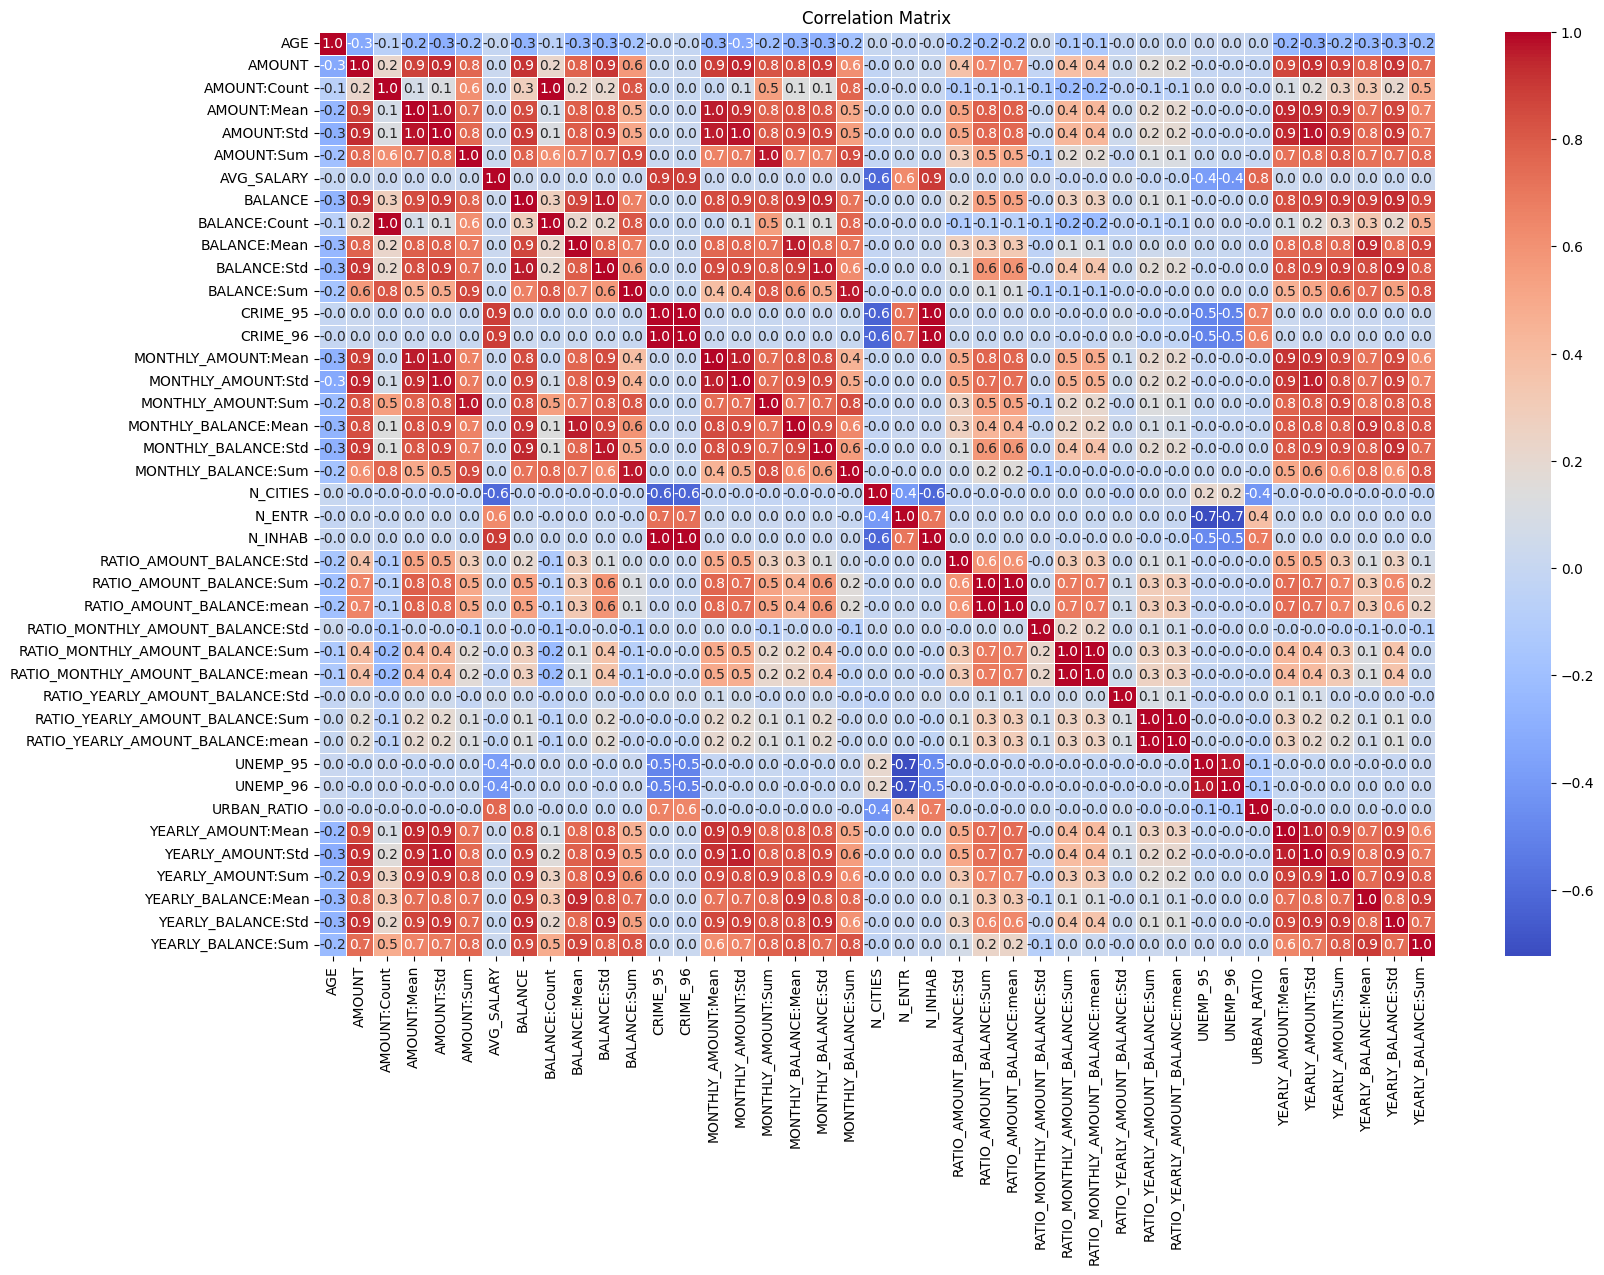

In [37]:
# First we calculate the correlation between all numerical variables

correlation_matrix = df[num_variables].corr()

plt.figure(figsize=(18, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.1f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [38]:
# We calculate the variation inflation factor (VIF) to better assess the results from the correlation matrix
df = df.replace([np.inf, -np.inf], np.nan)
df[num_variables] = df[num_variables].apply(lambda x: x.fillna(x.mean()), axis=0)

vif_data = pd.DataFrame()
vif_data["Variable"] = df[num_variables].columns
vif_data["VIF"] = [variance_inflation_factor(df[num_variables].values, i) for i in range(df[num_variables].shape[1])]

vif_data[vif_data['VIF'] < 10]

,Variable,VIF
0,AGE,9.043756
20,N_CITIES,8.283615
26,RATIO_MONTHLY_AMOUNT_BALANCE:Std,1.132374
29,RATIO_YEARLY_AMOUNT_BALANCE:Std,1.083142


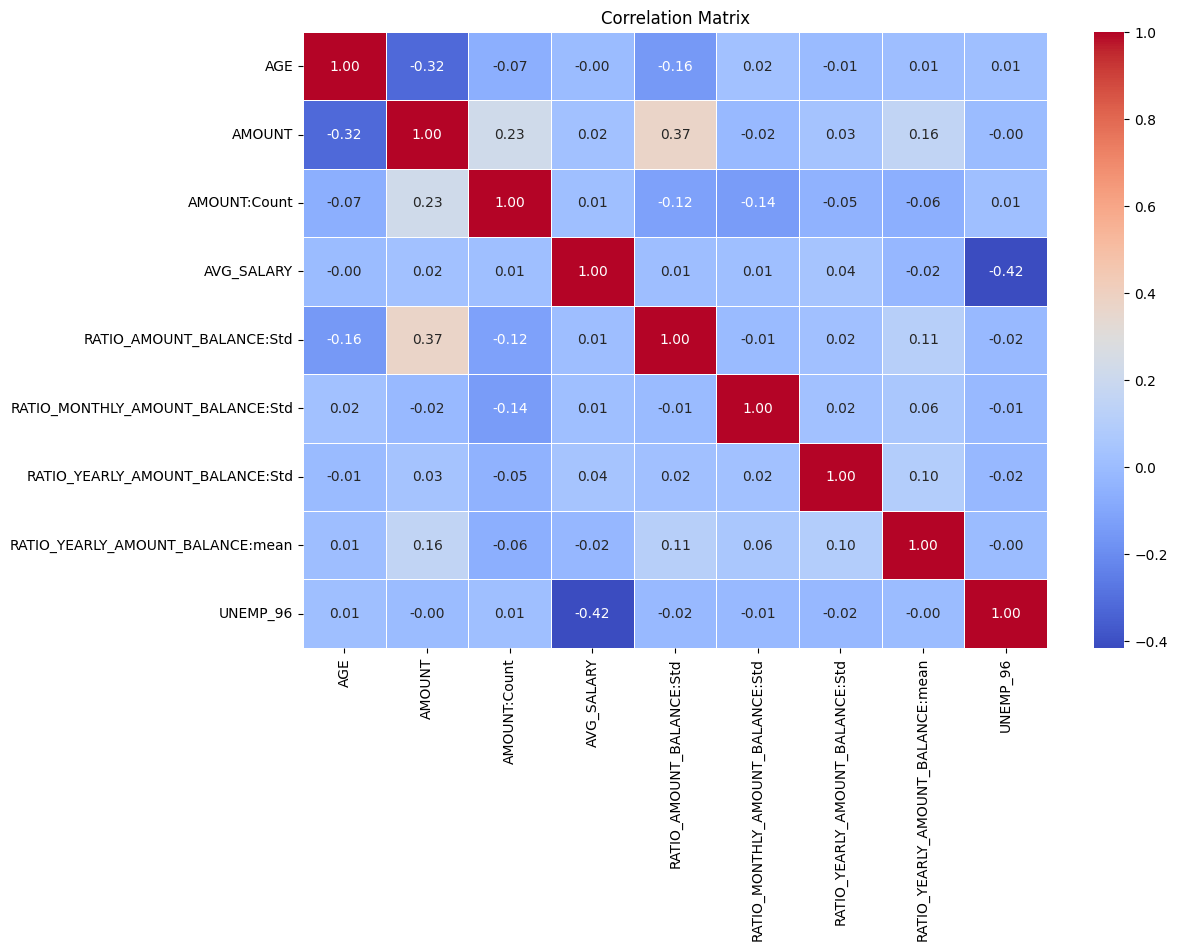

In [39]:
# Based on the results from the correlation matrix and VIF, we decide for the following numerical variables to keep
final_numerical_variables = ['AGE','AMOUNT','AMOUNT:Count','AVG_SALARY',
    'RATIO_AMOUNT_BALANCE:Std','RATIO_MONTHLY_AMOUNT_BALANCE:Std','RATIO_YEARLY_AMOUNT_BALANCE:Std',
    'RATIO_YEARLY_AMOUNT_BALANCE:mean','UNEMP_96']

correlation_matrix = df[final_numerical_variables].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [40]:
num_vars_to_drop = set(num_variables).difference(final_numerical_variables)
df = df.drop(columns=num_vars_to_drop)

## 2.2 Chi-squared test of independence (categorical variables)

In [41]:
results = {}
for i in range(len(cat_variables)):
    for j in range(i + 1, len(cat_variables)):
        cross_table = pd.crosstab(df[cat_variables[i]], df[cat_variables[j]])
        chi2, p, dof, expected = chi2_contingency(cross_table)
        results[f"{cat_variables[i]} vs {cat_variables[j]}"] = {'Chi-Squared': chi2, 'P-value': p}

results_df = pd.DataFrame.from_dict(results, orient='index')

results_df

,Chi-Squared,P-value
GENDER vs MOST_COMMON_TRANS_OPERATION,3.067850,0.546536
GENDER vs MOST_COMMON_TRANS_TYPE,0.323476,0.569526
MOST_COMMON_TRANS_OPERATION vs MOST_COMMON_TRANS_TYPE,1588.020362,0.000000


The results of the chi-squared test show that there is a statistically significant association between the variables 'MOST_COMMON_TRANS_OPERATION' and 'MOST_COMMON_TRANS_TYPE' (chi-squared test statistic = 1588, p-value = <0.001). This suggests that the likelihood both variables are dependent of each other. Suggesting that we can drop one of them.

In [42]:
num_vars_to_drop = df.columns[df.columns.str.contains("TYPE")]
df = df.drop(columns=num_vars_to_drop)

# 3. Splitting Data

Our strategy is to split the data in training and test datasets and perform **coarse classing** based on the weight of evidence of each feature (description below). This s data processing will be conducted in the training set only in order to avoid data leakeage and the test set will be binned in the same way based on the inference made on the training set.



In [43]:
df.head()

AGE   AMOUNT  AMOUNT:Count  AVG_SALARY GENDER  \
SET_SPLIT CLIENT_ID                                                  
TRAIN     1           28  12600.0           239        8968      F   
          2           53  42000.0           468       12541      M   
TEST      4           42  11253.0           114        9307      M   
TRAIN     7           69   5100.0            83        9045      M   
          8           60  11600.0           245        8541      F   

                    MOST_COMMON_TRANS_OPERATION  RATIO_AMOUNT_BALANCE:Std  \
SET_SPLIT CLIENT_ID                                                         
TRAIN     1                  WITHDRAWAL_IN_CASH                  0.473676   
          2                  WITHDRAWAL_IN_CASH                  0.693448   
TEST      4            REMITTANCE_TO_OTHER_BANK                  0.287445   
TRAIN     7                  WITHDRAWAL_IN_CASH                  0.505457   
          8                  WITHDRAWAL_IN_CASH                  0.361528   

                     RATIO_MONTHLY_AMOUNT_BALANCE:Std  \
SET_SPLIT CLIENT_ID                                     
TRAIN     1                                  0.935318   
          2                                  0.927735   
TEST      4                                  1.239189   
TRAIN     7                                  1.314700   
          8                                  0.598730   

                     RATIO_YEARLY_AMOUNT_BALANCE:Std  \
SET_SPLIT CLIENT_ID                                    
TRAIN     1                                 0.692325   
          2                                 0.870251   
TEST      4                                 0.570073   
TRAIN     7                                 0.708479   
          8                                 0.671780   

                     RATIO_YEARLY_AMOUNT_BALANCE:mean  TARGET  UNEMP_96  \
SET_SPLIT CLIENT_ID                                                       
TRAIN     1                                  0.106844     0.0      3.35   
          2                                  0.250617     1.0      0.43   
TEST      4                                  0.164192     0.0      4.43   
TRAIN     7                                  0.109408     0.0      3.60   
          8                                  0.479364     0.0      2.97   

                     MOST_COMMON_TRANS_OPERATION:COLLECTION_FROM_OTHER_BANK  \
SET_SPLIT CLIENT_ID                                                           
TRAIN     1                                                          0        
          2                                                          0        
TEST      4                                                          0        
TRAIN     7                                                          0        
          8                                                          0        

                     MOST_COMMON_TRANS_OPERATION:CREDIT_IN_CASH  \
SET_SPLIT CLIENT_ID                                               
TRAIN     1                                                   0   
          2                                                   0   
TEST      4                                                   0   
TRAIN     7                                                   0   
          8                                                   0   

                     MOST_COMMON_TRANS_OPERATION:OTHER  \
SET_SPLIT CLIENT_ID                                      
TRAIN     1                                          0   
          2                                          0   
TEST      4                                          0   
TRAIN     7                                          0   
          8                                          0   

                     MOST_COMMON_TRANS_OPERATION:REMITTANCE_TO_OTHER_BANK  \
SET_SPLIT CLIENT_ID                                                         
TRAIN     1                                                          0      
         

In [44]:
# We change the default definition so 1 represent the 'NO BAD' customers. This will be helpful when getting models. So higher probabilities (scores) mean better customers
df['TARGET'] = np.where(df['TARGET'] == 1, 0, 1)

X = df.drop('TARGET', axis = 1)
y = df['TARGET']

In [45]:
loan_data_inputs_train = X[X.index.get_level_values('SET_SPLIT') == 'TRAIN']
loan_data_targets_train = y[y.index.get_level_values('SET_SPLIT') == 'TRAIN']
loan_data_inputs_test = X[X.index.get_level_values('SET_SPLIT') == 'TEST']
loan_data_targets_test = y[y.index.get_level_values('SET_SPLIT') == 'TEST']

Our model will predict the likelihood of a customer being good and all input variables will be as in form of binary categorical variables. The reason for that is our logistic regression model will output some model coefficients, and intuitively we want the sign of these coefficients to represent a positive effect (good creditworthiness) to a customer. Therefore, having a positive target to predict will make model coefficients easy-to-interpret.

## 3.1 Weight of Evidence (WoE) transformation

For continuous variables we will do **fine classing** to create bundles and then apply the WoE to find categories to merge (**coarse classing**) to reduce the number of categories and improve our logistic regression model due to the effects of the **curse of dimensionality**.

The Weight of evidence will tell us the ability of a independent variable to predict the target. The WoE analyses the rate of good and bad customers across categories of a variable. 



**WoE = ln(Proportion of Good Customers in the Category / Proportion of Bad Customers in the Category)**

where:

Proportion of Good Customers in the Category is the number of good customers (e.g., customers with a positive outcome) divided by the total number of customers in that category.
Proportion of Bad Customers in the Category is the number of bad customers (e.g., customers with a negative outcome) divided by the total number of customers in that category.

The WoE measures the "evidence" provided by a category with respect to the target variable. Positive WoE values indicate higher odds of the positive outcome, and negative WoE values indicate higher odds of the negative outcome. WoE-transformed features are often used as inputs for logistic regression models.

From the WoE we will calculate the Information Value (IV) which is another important mathematical information-related metric, which measures the overall predictive power of a variable by summing up the contributions of each category's WoE. The IV is calculated as follows:

**IV = Σ(Proportion of Good Customers - Proportion of Bad Customers) * WoE**


In [46]:
################
df_inputs_prepr = loan_data_inputs_train
df_targets_prepr = loan_data_targets_train
################
# df_inputs_prepr = loan_data_inputs_test
# df_targets_prepr = loan_data_targets_test

In [47]:
# WoE function for discrete unordered variables
def woe_discrete(df:pd.DataFrame, discrete_variabe_name:str, good_bad_variable_df:pd.DataFrame) -> pd.DataFrame:
    epsilon = 1e-6  # A small constant to prevent division by zero
    # Concatenates two dataframes along the columns.
    df = pd.concat([df[discrete_variabe_name], good_bad_variable_df], axis = 1)
    # Here we calculate the mean AND count of the values for each unique value of the discrete_variabe_name. We get the final count and proportion of good/bads customers
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    # Changes the names of the columns of a dataframe.
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    # We calculate the number of good and bad customers per segment (unique category)
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    # We calculate the proportion of good and bad customers per segment (unique category)
    df['prop_n_good'] = df['n_good'] / (df['n_good'].sum() + epsilon)  # Adding epsilon to avoid division by zero
    df['prop_n_bad'] = df['n_bad'] / (df['n_bad'].sum() + epsilon)  # Adding epsilon to avoid division by zero
    df['WoE'] = np.log((df['prop_n_good'] + epsilon) / (df['prop_n_bad'] + epsilon))  # Adding epsilon to avoid division by zero
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    # We calculate the information value
    df['Information Value'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['Information Value'] = df['Information Value'].sum()
    return df
# The function takes 3 arguments: a dataframe, a string, and a dataframe. The function returns a dataframe as a result.

In [48]:
# Below we define a function that takes 2 arguments: a dataframe and a number.
# The number parameter has a default value of 0.
# This means that if we call the function and omit the number parameter, it will be executed with it having a value of 0.
# The function displays a graph.
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    # Turns the values of the column with index 0 to strings, makes an array from these strings, and passes it to variable x.
    y = df_WoE['WoE']
    # Selects a column with label 'WoE' and passes it to variable y.
    plt.figure(figsize=(18, 6))
    # Sets the graph size to width 18 x height 6.
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    # Plots the datapoints with coordiantes variable x on the x-axis and variable y on the y-axis.
    # Sets the marker for each datapoint to a circle, the style line between the points to dashed, and the color to black.
    plt.xlabel(df_WoE.columns[0])
    # Names the x-axis with the name of the column with index 0.
    plt.ylabel('Weight of Evidence')
    # Names the y-axis 'Weight of Evidence'.
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    # Names the grapth 'Weight of Evidence by ' the name of the column with index 0.
    plt.xticks(rotation=rotation_of_x_axis_labels, ha='right')  # Rotates and aligns x-axis labels to the right

    for i, val in enumerate(y):
        plt.text(i, val, str(round(val, 2)), ha='center', va='bottom', fontsize=9)

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    # Rotates the labels of the x-axis a predefined number of degrees.

## 3.2 Fine and Coarse Classing based on WoE

In [49]:
sns.set()

In [50]:
# 'GENDER'
df_temp = woe_discrete(df_inputs_prepr, 'GENDER', df_targets_prepr)
# We execute the function we defined with the necessary arguments: a dataframe, a string, and a dataframe.
# We store the result in a dataframe.
df_temp

,GENDER,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,Information Value
0,M,1789,0.847401,0.515117,1516.0,273.0,0.514946,0.516068,-0.002177,NaN,NaN,0.000005
1,F,1684,0.847981,0.484883,1428.0,256.0,0.485054,0.483932,0.002317,0.00058,0.004494,0.000005


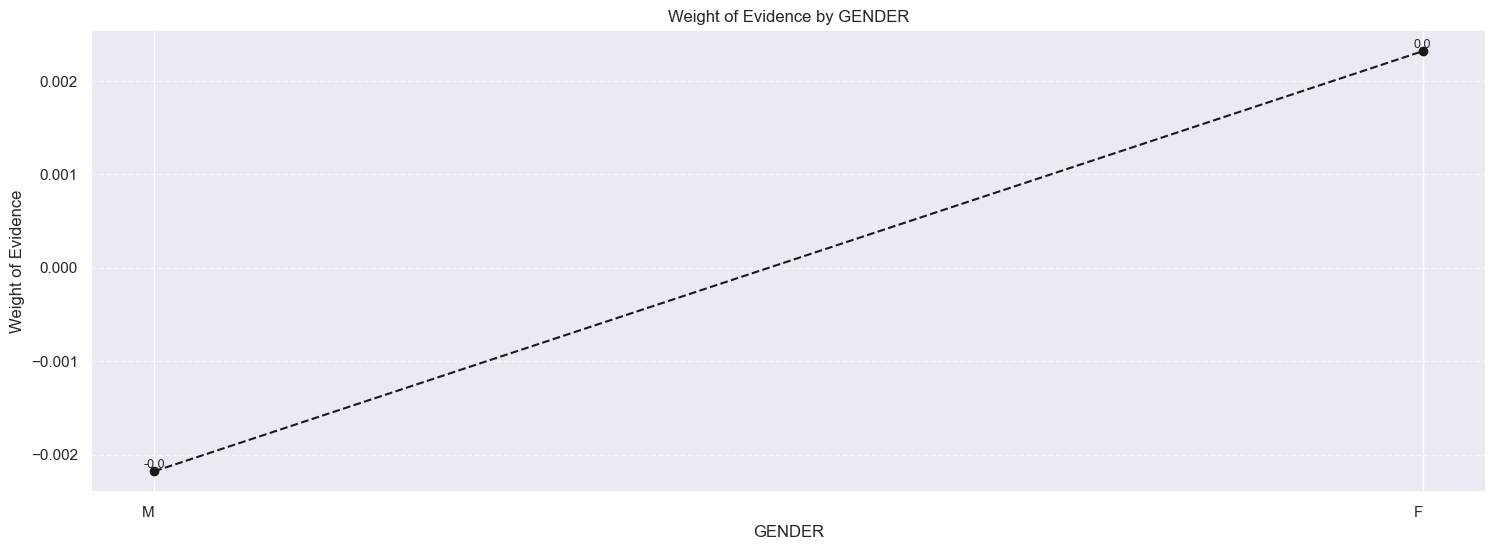

In [51]:
plot_by_woe(df_temp)

Based on the below example we will take as reference only these categories with lowest WoE, example: **MOST_COMMON_TRANS_OPERATION:REMITTANCE_TO_OTHER_BANK**

In [52]:
# 'MOST_COMMON_TRANS_OPERATION'
df_temp = woe_discrete(df_inputs_prepr, 'MOST_COMMON_TRANS_OPERATION', df_targets_prepr)
# We execute the function we defined with the necessary arguments: a dataframe, a string, and a dataframe.
# We store the result in a dataframe.
df_temp

,MOST_COMMON_TRANS_OPERATION,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,Information Value
0,REMITTANCE_TO_OTHER_BANK,433,0.785219,0.124676,340.0,93.0,0.115489,0.175803,-0.420187,NaN,NaN,0.092548
1,WITHDRAWAL_IN_CASH,2919,0.852004,0.840484,2487.0,432.0,0.844769,0.816635,0.033871,0.066785,0.454058,0.092548
2,OTHER,34,0.941176,0.009790,32.0,2.0,0.010870,0.003781,1.055880,0.089172,1.022009,0.092548
3,CREDIT_IN_CASH,82,0.975610,0.023611,80.0,2.0,0.027174,0.003781,1.972116,0.034433,0.916236,0.092548
4,COLLECTION_FROM_OTHER_BANK,5,1.000000,0.001440,5.0,0.0,0.001698,0.000000,7.438013,0.024390,5.465897,0.092548


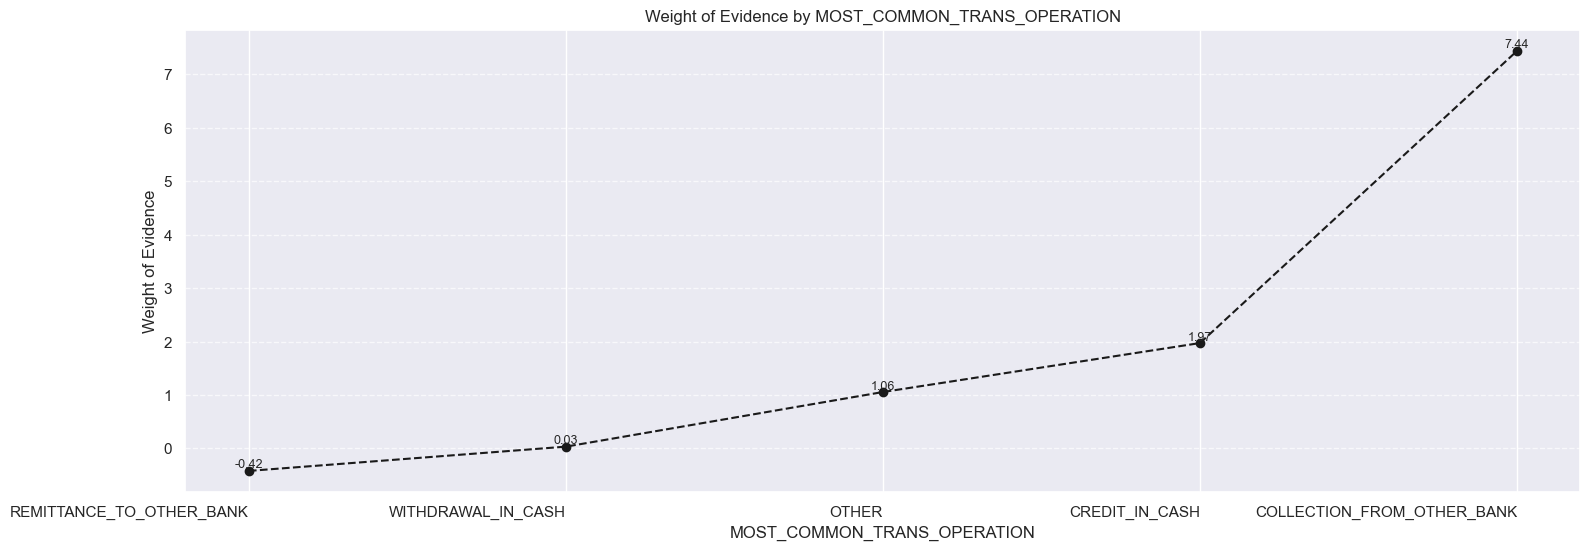

In [53]:
plot_by_woe(df_temp)

In [54]:
df_inputs_prepr['MOST_COMMON_TRANS_OPERATION:OTHER_CREDIT_IN_CASH_COLLECTION_FROM_OTHER_BANK'] = sum([df_inputs_prepr['MOST_COMMON_TRANS_OPERATION:OTHER'], df_inputs_prepr['MOST_COMMON_TRANS_OPERATION:CREDIT_IN_CASH'],
                                                                                                        df_inputs_prepr['MOST_COMMON_TRANS_OPERATION:COLLECTION_FROM_OTHER_BANK']])

In [55]:
# WoE function for ordered discrete and continuous variables

def woe_ordered_continuous(df:pd.DataFrame, discrete_variable_name:str, good_bad_variable_df:pd.DataFrame) -> pd.DataFrame:
    epsilon = 1e-8  # A small constant to prevent division by zero
    
    df = pd.concat([df[discrete_variable_name], good_bad_variable_df], axis=1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index=False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index=False)[df.columns.values[1]].mean()], axis=1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / (df['n_good'].sum() + epsilon)  # Adding epsilon to avoid division by zero
    df['prop_n_bad'] = df['n_bad'] / (df['n_bad'].sum() + epsilon)  # Adding epsilon to avoid division by zero
    df['WoE'] = np.log((df['prop_n_good'] + epsilon) / (df['prop_n_bad'] + epsilon))  # Adding epsilon to avoid division by zero
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

# Here we define a function similar to the one above, ...
# ... with one slight difference: we order the results by the values of a different column.
# The function takes 3 arguments: a dataframe, a string, and a dataframe. The function returns a dataframe as a result.

In [56]:
df_inputs_prepr

AGE   AMOUNT  AMOUNT:Count  AVG_SALARY GENDER  \
SET_SPLIT CLIENT_ID                                                  
TRAIN     1           28  12600.0           239        8968      F   
          2           53  42000.0           468       12541      M   
          7           69   5100.0            83        9045      M   
          8           60  11600.0           245        8541      F   
          9           63  33975.0           129        8441      M   
...                  ...      ...           ...         ...    ...   
          13931       57  62800.0           365       11277      M   
          13955       53  64800.0           302       12541      F   
          13968       30  40521.0           378        8814      M   
          13971       36  24212.0           343        8110      F   
          13998       45  52800.0           251       10673      F   

                    MOST_COMMON_TRANS_OPERATION  RATIO_AMOUNT_BALANCE:Std  \
SET_SPLIT CLIENT_ID                                                         
TRAIN     1                  WITHDRAWAL_IN_CASH                  0.473676   
          2                  WITHDRAWAL_IN_CASH                  0.693448   
          7                  WITHDRAWAL_IN_CASH                  0.505457   
          8                  WITHDRAWAL_IN_CASH                  0.361528   
          9                  WITHDRAWAL_IN_CASH                  0.728214   
...                                         ...                       ...   
          13931              WITHDRAWAL_IN_CASH                  0.425833   
          13955              WITHDRAWAL_IN_CASH                  0.788209   
          13968              WITHDRAWAL_IN_CASH                  0.618313   
          13971        REMITTANCE_TO_OTHER_BANK                  0.558693   
          13998              WITHDRAWAL_IN_CASH                  0.631543   

                     RATIO_MONTHLY_AMOUNT_BALANCE:Std  \
SET_SPLIT CLIENT_ID                                     
TRAIN     1                                  0.935318   
          2                                  0.927735   
          7                                  1.314700   
          8                                  0.598730   
          9                                  1.149508   
...                                               ...   
          13931                              0.760242   
          13955                              1.163985   
          13968                              0.813929   
          13971                              0.824576   
          13998                              1.270121   

                     RATIO_YEARLY_AMOUNT_BALANCE:Std  \
SET_SPLIT CLIENT_ID                                    
TRAIN     1                                 0.692325   
          2                                 0.870251   
          7                                 0.708479   
          8                                 0.671780   
          9                                 4.735598   
...                                              ...   
          13931                             0.592866   
          13955                             0.892284   
          13968                             1.000791   
          13971                             0.747007   
          13998                             0.886759   

                     RATIO_YEARLY_AMOUNT_BALANCE:mean  UNEMP_96  \
SET_SPLIT CLIENT_ID                                               
TRAIN     1                                  0.106844      3.35   
          2                                  0.250617      0.43   
          7                                  0.109408      3.60   
          8                                  0.479364      2.97   
          9                                  0.443991      4.48   
...                                               ...       ...   
          13931                              0.301095      1.44   
          13955                   

In [57]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'AGE', df_targets_prepr)
# We calculate weight of evidence.
df_temp

,AGE,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,18,68,0.808824,0.019580,55.0,13.0,0.018682,0.024575,-0.274152,NaN,NaN,2.607933
1,19,74,0.810811,0.021307,60.0,14.0,0.020380,0.026465,-0.261249,0.001987,0.012903,2.607933
2,20,79,0.911392,0.022747,72.0,7.0,0.024457,0.013233,0.614220,0.100582,0.875468,2.607933
3,21,75,0.920000,0.021595,69.0,6.0,0.023437,0.011342,0.725811,0.008608,0.111591,2.607933
4,22,84,0.833333,0.024187,70.0,14.0,0.023777,0.026465,-0.107098,0.086667,0.832909,2.607933
...,...,...,...,...,...,...,...,...,...,...,...,...
59,77,22,1.000000,0.006335,22.0,0.0,0.007473,0.000000,13.524200,0.000000,0.374693,2.607933
60,78,37,1.000000,0.010654,37.0,0.0,0.012568,0.000000,14.044075,0.000000,0.519875,2.607933
61,79,25,1.000000,0.007198,25.0,0.0,0.008492,0.000000,13.652033,0.000000,0.392042,2.607933
62,80,26,1.000000,0.007486,26.0,0.0,0.008832,0.000000,13.691254,0.000000,0.039221,2.607933


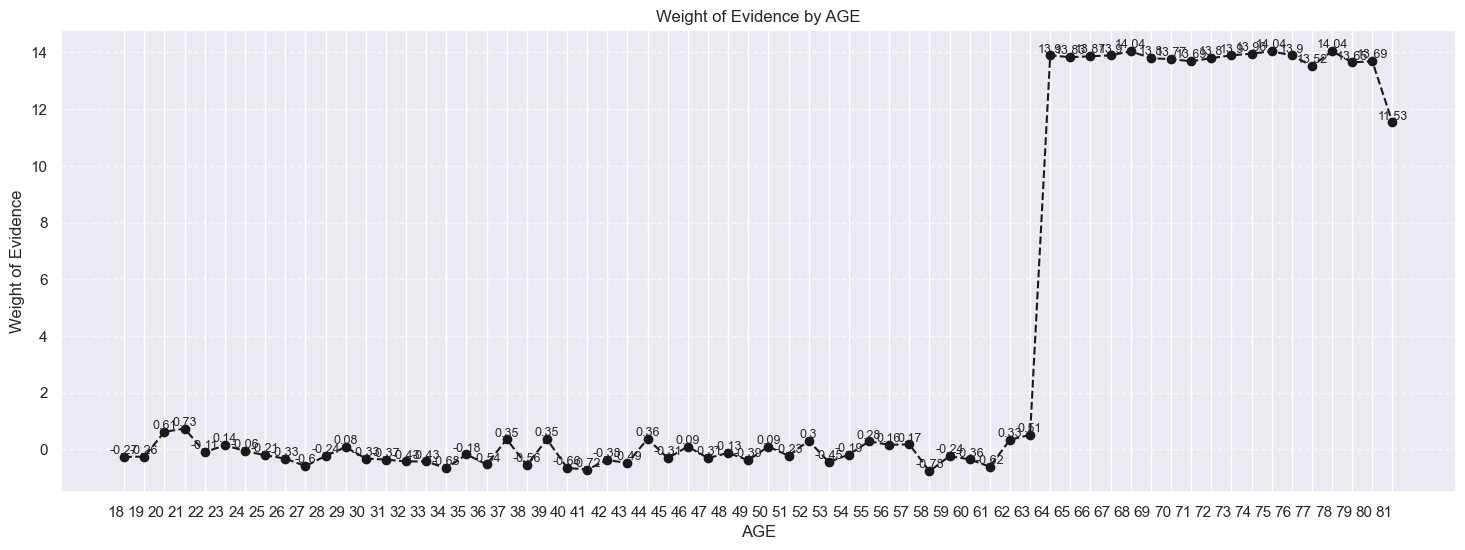

In [58]:
plot_by_woe(df_temp)

In [59]:
df_inputs_prepr['AGE:18-22'] = np.where(df_inputs_prepr['AGE'].isin(range(18,23)), 1, 0)
df_inputs_prepr['AGE:22-27'] = np.where(df_inputs_prepr['AGE'].isin(range(23,28)), 1, 0)
df_inputs_prepr['AGE:27-34'] = np.where(df_inputs_prepr['AGE'].isin(range(28,35)), 1, 0)
df_inputs_prepr['AGE:34-43'] = np.where(df_inputs_prepr['AGE'].isin(range(35,44)), 1, 0)
df_inputs_prepr['AGE:44-57'] = np.where(df_inputs_prepr['AGE'].isin(range(44,58)), 1, 0)
df_inputs_prepr['AGE:58-63'] = np.where(df_inputs_prepr['AGE'].isin(range(58,64)), 1, 0)
df_inputs_prepr['AGE:64-75'] = np.where(df_inputs_prepr['AGE'].isin(range(64,76)), 1, 0)
df_inputs_prepr['AGE:75+'] = np.where(df_inputs_prepr['AGE'] > 75, 1, 0)

In [60]:
df_inputs_prepr['AMOUNT:Count_factor'] =pd.cut(df_inputs_prepr['AMOUNT:Count'], 50) # we do fine classing here in 50 buckets
df_temp = woe_ordered_continuous(df_inputs_prepr, 'AMOUNT:Count_factor', df_targets_prepr)
df_temp

,AMOUNT:Count_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(8.337, 22.26]",20,1.000000,0.005759,20.0,0.0,0.006793,0.000000,13.428890,NaN,NaN,0.877771
1,"(22.26, 35.52]",24,1.000000,0.006910,24.0,0.0,0.008152,0.000000,13.611211,0.000000,0.182321,0.877771
2,"(35.52, 48.78]",33,1.000000,0.009502,33.0,0.0,0.011209,0.000000,13.929665,0.000000,0.318453,0.877771
3,"(48.78, 62.04]",81,0.975309,0.023323,79.0,2.0,0.026834,0.003781,1.959762,0.024691,11.969902,0.877771
4,"(62.04, 75.3]",107,0.953271,0.030809,102.0,5.0,0.034647,0.009452,1.298998,0.022038,0.660764,0.877771
5,"(75.3, 88.56]",116,0.931034,0.033401,108.0,8.0,0.036685,0.015123,0.886153,0.022237,0.412845,0.877771
6,"(88.56, 101.82]",131,0.900763,0.037720,118.0,13.0,0.040082,0.024575,0.489199,0.030271,0.396954,0.877771
7,"(101.82, 115.08]",183,0.879781,0.052692,161.0,22.0,0.054687,0.041588,0.273826,0.020982,0.215373,0.877771
8,"(115.08, 128.34]",146,0.904110,0.042039,132.0,14.0,0.044837,0.026465,0.527208,0.024328,0.253383,0.877771
9,"(128.34, 141.6]",139,0.913669,0.040023,127.0,12.0,0.043139,0.022684,0.642744,0.009559,0.115536,0.877771


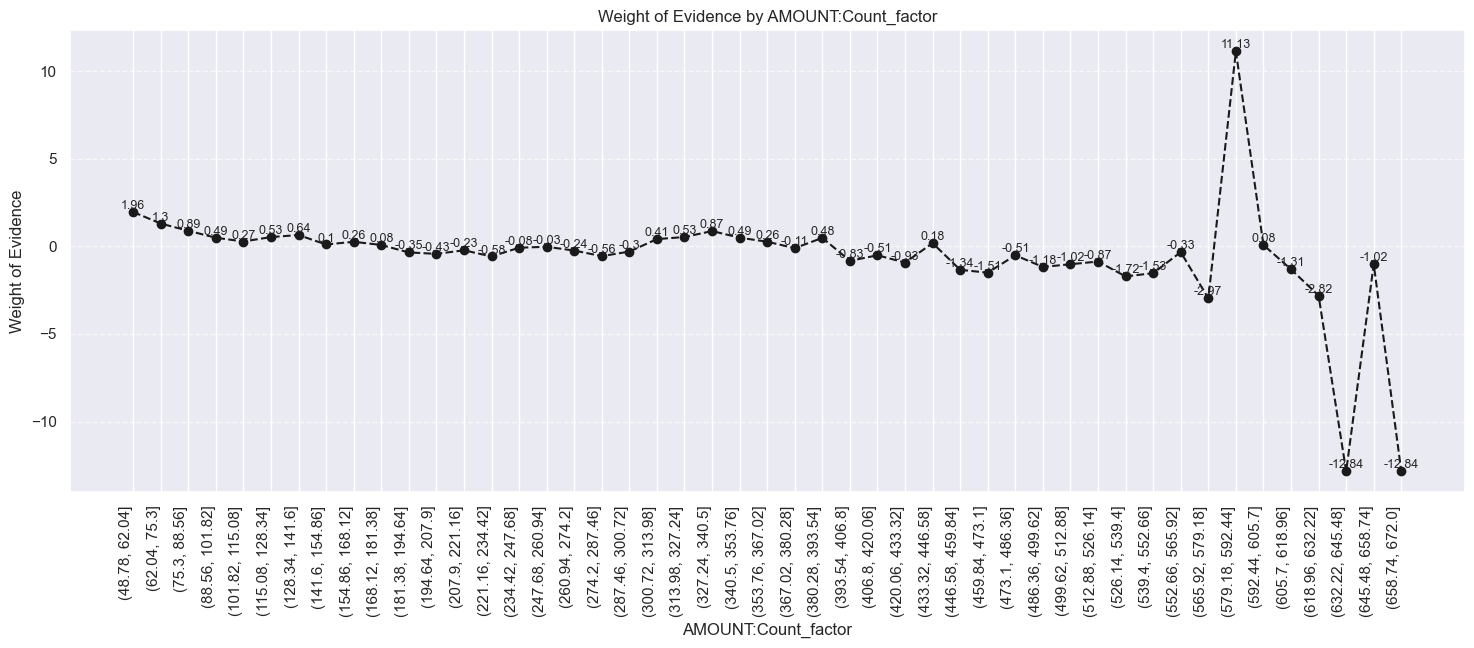

In [61]:
plot_by_woe(df_temp.iloc[3: , : ], 90)

In [62]:
df_inputs_prepr['AMOUNT:Count:<49'] = np.where(df_inputs_prepr['AMOUNT:Count'] <= 49, 1, 0)
df_inputs_prepr['AMOUNT:Count:50-90'] = np.where(df_inputs_prepr['AMOUNT:Count'].isin(range(50, 90)), 1, 0)
df_inputs_prepr['AMOUNT:Count:90-248'] = np.where(df_inputs_prepr['AMOUNT:Count'].isin(range(90, 248)), 1, 0)
df_inputs_prepr['AMOUNT:Count:248-301'] = np.where(df_inputs_prepr['AMOUNT:Count'].isin(range(248, 301)), 1, 0)
df_inputs_prepr['AMOUNT:Count:301-340'] = np.where(df_inputs_prepr['AMOUNT:Count'].isin(range(301, 340)), 1, 0)
df_inputs_prepr['AMOUNT:Count:340-394'] = np.where(df_inputs_prepr['AMOUNT:Count'].isin(range(340, 394)), 1, 0)
df_inputs_prepr['AMOUNT:Count:394-433'] = np.where(df_inputs_prepr['AMOUNT:Count'].isin(range(394, 433)), 1, 0)
df_inputs_prepr['AMOUNT:Count:433-566'] = np.where(df_inputs_prepr['AMOUNT:Count'].isin(range(433, 566)), 1, 0)
df_inputs_prepr['AMOUNT:Count:+566'] = np.where(df_inputs_prepr['AMOUNT:Count'] >= 566, 1, 0)

In [63]:
df_inputs_prepr['AMOUNT_factor'] =pd.cut(df_inputs_prepr['AMOUNT'], 50) # we do fine classing here in 50 buckets
df_temp = woe_ordered_continuous(df_inputs_prepr, 'AMOUNT_factor', df_targets_prepr)
df_temp

,AMOUNT_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(2816.501, 4590.98]",164,1.000000,0.047221,164.0,0.0,0.055707,0.000000,15.533023,NaN,NaN,2.771741
1,"(4590.98, 6280.96]",178,1.000000,0.051253,178.0,0.0,0.060462,0.000000,15.614940,0.000000,0.081917,2.771741
2,"(6280.96, 7970.94]",151,0.986755,0.043478,149.0,2.0,0.050611,0.003781,2.594261,0.013245,13.020679,2.771741
3,"(7970.94, 9660.92]",186,0.989247,0.053556,184.0,2.0,0.062500,0.003781,2.805250,0.002492,0.210989,2.771741
4,"(9660.92, 11350.9]",189,0.957672,0.054420,181.0,8.0,0.061481,0.015123,1.402519,0.031575,1.402731,2.771741
5,"(11350.9, 13040.88]",185,0.935135,0.053268,173.0,12.0,0.058764,0.022684,0.951849,0.022537,0.450670,2.771741
6,"(13040.88, 14730.86]",131,0.961832,0.037720,126.0,5.0,0.042799,0.009452,1.510307,0.026697,0.558458,2.771741
7,"(14730.86, 16420.84]",85,0.882353,0.024475,75.0,10.0,0.025476,0.018904,0.298367,0.079479,1.211940,2.771741
8,"(16420.84, 18110.82]",71,0.887324,0.020443,63.0,8.0,0.021399,0.015123,0.347157,0.004971,0.048790,2.771741
9,"(18110.82, 19800.8]",72,0.833333,0.020731,60.0,12.0,0.020380,0.022684,-0.107098,0.053991,0.454255,2.771741


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


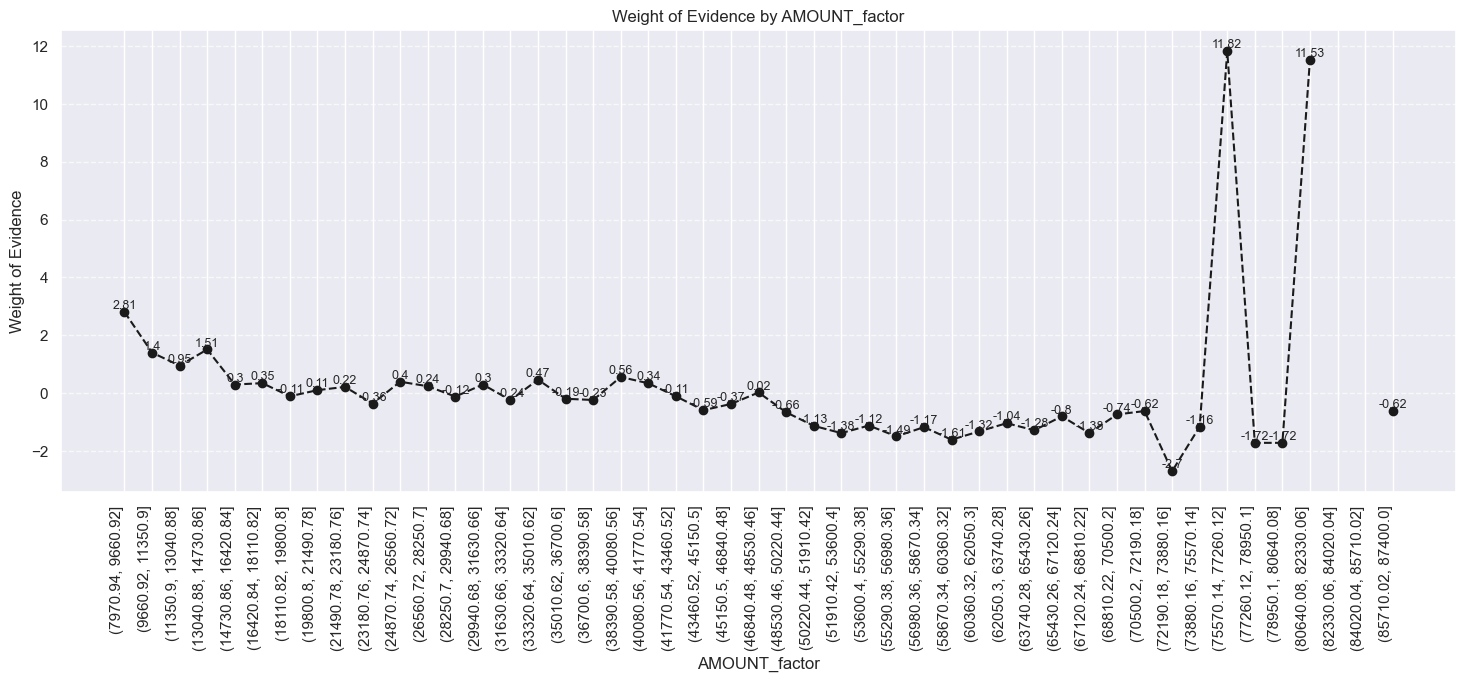

In [64]:
plot_by_woe(df_temp.iloc[3: , : ], 90)

In [65]:
df_inputs_prepr['AMOUNT:<6281'] = np.where(df_inputs_prepr['AMOUNT'] <= 6281, 1, 0)
df_inputs_prepr['AMOUNT:6281-24871'] = np.where(df_inputs_prepr['AMOUNT'].isin(range(6281, 24871)), 1, 0)
df_inputs_prepr['AMOUNT:24871-40081'] = np.where(df_inputs_prepr['AMOUNT'].isin(range(24871, 40081)), 1, 0)
df_inputs_prepr['AMOUNT:40081-45150'] = np.where(df_inputs_prepr['AMOUNT'].isin(range(40081, 45150)), 1, 0)
df_inputs_prepr['AMOUNT:45150-50220'] = np.where(df_inputs_prepr['AMOUNT'].isin(range(45150, 50220)), 1, 0)
df_inputs_prepr['AMOUNT:50220-70500'] = np.where(df_inputs_prepr['AMOUNT'].isin(range(50220, 70500)), 1, 0)
df_inputs_prepr['AMOUNT:+70500'] = np.where(df_inputs_prepr['AMOUNT'] >= 70500, 1, 0)


In [66]:
df_inputs_prepr['AVG_SALARY_factor'] =pd.cut(df_inputs_prepr['AVG_SALARY'], 20) # we do fine classing here in 50 buckets
df_temp = woe_ordered_continuous(df_inputs_prepr, 'AVG_SALARY_factor', df_targets_prepr)
df_temp

,AVG_SALARY_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(8105.569, 8331.55]",283,0.837456,0.081486,237.0,46.0,0.080503,0.086957,-0.077117,NaN,NaN,0.025735
1,"(8331.55, 8553.1]",617,0.829822,0.177656,512.0,105.0,0.173913,0.198488,-0.132172,0.007634,0.055054,0.025735
2,"(8553.1, 8774.65]",481,0.846154,0.138497,407.0,74.0,0.138247,0.139887,-0.011788,0.016332,0.120384,0.025735
3,"(8774.65, 8996.2]",470,0.848936,0.135330,399.0,71.0,0.135530,0.134216,0.009745,0.002782,0.021533,0.025735
4,"(8996.2, 9217.75]",176,0.863636,0.050677,152.0,24.0,0.051630,0.045369,0.129291,0.014700,0.119545,0.025735
5,"(9217.75, 9439.3]",163,0.865031,0.046933,141.0,22.0,0.047894,0.041588,0.141181,0.001394,0.011891,0.025735
6,"(9439.3, 9660.85]",182,0.835165,0.052404,152.0,30.0,0.051630,0.056711,-0.093853,0.029866,0.235034,0.025735
7,"(9660.85, 9882.4]",93,0.881720,0.026778,82.0,11.0,0.027853,0.020794,0.292288,0.046556,0.386141,0.025735
8,"(9882.4, 10103.95]",225,0.808889,0.064785,182.0,43.0,0.061821,0.081285,-0.273729,0.072832,0.566017,0.025735
9,"(10103.95, 10325.5]",132,0.863636,0.038007,114.0,18.0,0.038723,0.034026,0.129291,0.054747,0.403020,0.025735


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


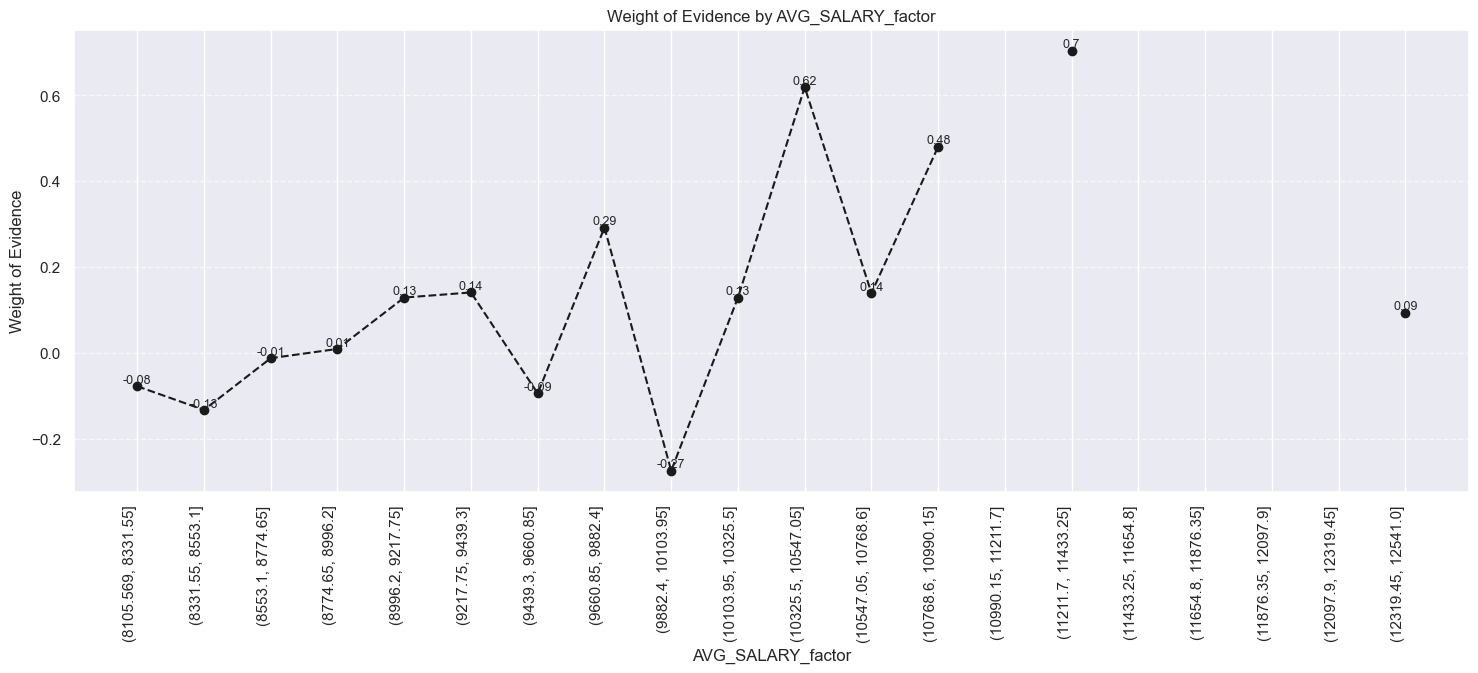

In [67]:
plot_by_woe(df_temp, 90)

In [68]:
df_inputs_prepr['AVG_SALARY:<8332'] = np.where(df_inputs_prepr['AVG_SALARY'] <= 8332, 1, 0)
df_inputs_prepr['AVG_SALARY:8332-9440'] = np.where(df_inputs_prepr['AVG_SALARY'].isin(range(8332, 9440)), 1, 0)
df_inputs_prepr['AVG_SALARY:9440-9661'] = np.where(df_inputs_prepr['AVG_SALARY'].isin(range(9440, 9661)), 1, 0)
df_inputs_prepr['AVG_SALARY:9661-9882'] = np.where(df_inputs_prepr['AVG_SALARY'].isin(range(9661, 9882)), 1, 0)
df_inputs_prepr['AVG_SALARY:9882-10104'] = np.where(df_inputs_prepr['AVG_SALARY'].isin(range(9882, 10104)), 1, 0)
df_inputs_prepr['AVG_SALARY:10104-12320'] = np.where(df_inputs_prepr['AVG_SALARY'].isin(range(10104, 12320)), 1, 0)
df_inputs_prepr['AVG_SALARY:+12320'] = np.where(df_inputs_prepr['AVG_SALARY'] >= 12320, 1, 0)


In [69]:
df_inputs_prepr['RATIO_AMOUNT_BALANCE:Std_factor'] =pd.cut(df_inputs_prepr['RATIO_AMOUNT_BALANCE:Std'], 20) # we do fine classing here in 50 buckets
df_temp = woe_ordered_continuous(df_inputs_prepr, 'RATIO_AMOUNT_BALANCE:Std_factor', df_targets_prepr)
df_temp

,RATIO_AMOUNT_BALANCE:Std_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(0.0612, 0.117]",12,1.000000,0.003455,12.0,0.0,0.004076,0.000000,12.918065,NaN,NaN,0.345951
1,"(0.117, 0.171]",36,0.972222,0.010366,35.0,1.0,0.011889,0.001890,1.838808,0.027778,11.079258,0.345951
2,"(0.171, 0.226]",84,0.976190,0.024187,82.0,2.0,0.027853,0.003781,1.997034,0.003968,0.158226,0.345951
3,"(0.226, 0.28]",111,0.963964,0.031961,107.0,4.0,0.036345,0.007561,1.569997,0.012227,0.427036,0.345951
4,"(0.28, 0.334]",174,0.942529,0.050101,164.0,10.0,0.055707,0.018904,1.080745,0.021435,0.489252,0.345951
5,"(0.334, 0.389]",278,0.920863,0.080046,256.0,22.0,0.086957,0.041588,0.737599,0.021665,0.343146,0.345951
6,"(0.389, 0.443]",353,0.847025,0.101641,299.0,54.0,0.101562,0.102079,-0.005077,0.073838,0.742675,0.345951
7,"(0.443, 0.498]",491,0.828921,0.141376,407.0,84.0,0.138247,0.158790,-0.138540,0.018105,0.133463,0.345951
8,"(0.498, 0.552]",466,0.832618,0.134178,388.0,78.0,0.131793,0.147448,-0.112240,0.003697,0.026300,0.345951
9,"(0.552, 0.606]",373,0.798928,0.107400,298.0,75.0,0.101223,0.141777,-0.336931,0.033690,0.224691,0.345951


posx and posy should be finite values
posx and posy should be finite values


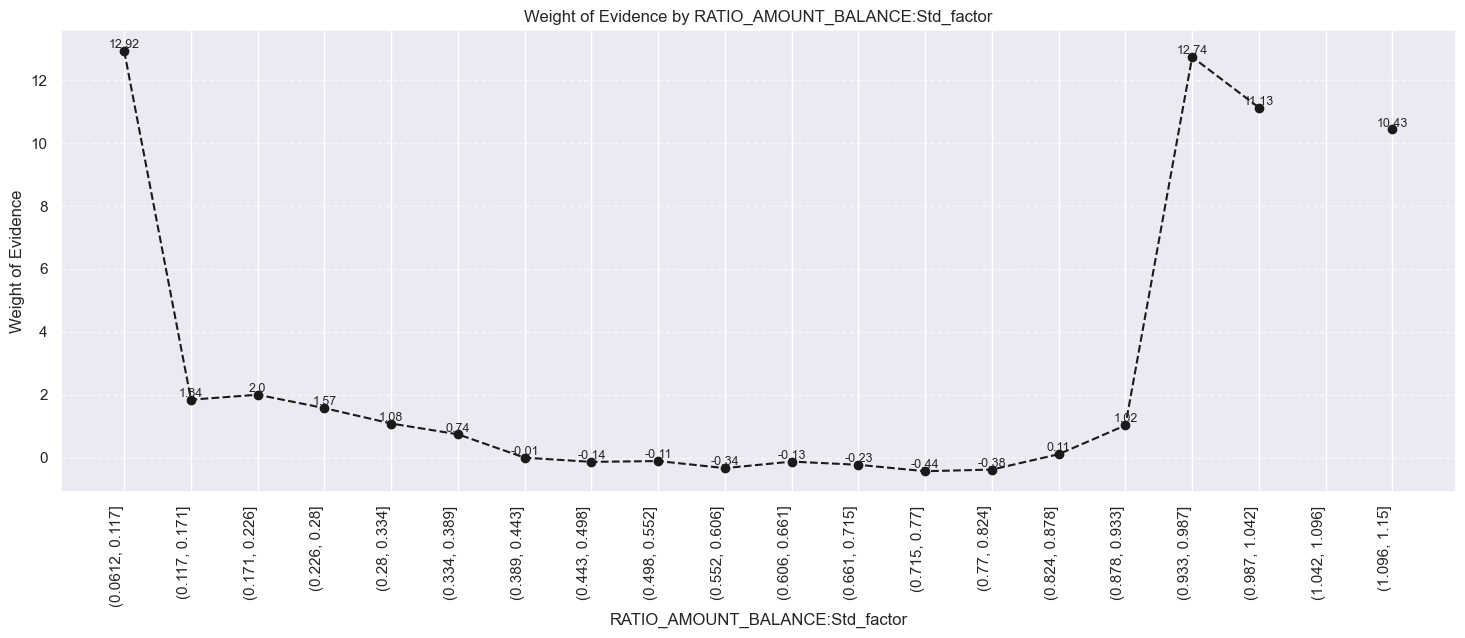

In [70]:
plot_by_woe(df_temp, 90)

In [71]:
df_inputs_prepr['RATIO_AMOUNT_BALANCE:Std:<0.117'] = np.where(df_inputs_prepr['RATIO_AMOUNT_BALANCE:Std'] <= 0.117, 1, 0)
df_inputs_prepr['RATIO_AMOUNT_BALANCE:Std:0.117-0.443'] = np.where((df_inputs_prepr['RATIO_AMOUNT_BALANCE:Std'] > 0.117) & (df_inputs_prepr['RATIO_AMOUNT_BALANCE:Std'] <= 0.443) , 1, 0)
df_inputs_prepr['RATIO_AMOUNT_BALANCE:Std:0.443-0.824'] = np.where((df_inputs_prepr['RATIO_AMOUNT_BALANCE:Std'] > 0.443) & (df_inputs_prepr['RATIO_AMOUNT_BALANCE:Std'] <= 0.824), 1, 0)
df_inputs_prepr['RATIO_AMOUNT_BALANCE:Std:0.824-0.993'] = np.where((df_inputs_prepr['RATIO_AMOUNT_BALANCE:Std'] > 0.824) & (df_inputs_prepr['RATIO_AMOUNT_BALANCE:Std'] <= 0.993), 1, 0)
df_inputs_prepr['RATIO_AMOUNT_BALANCE:Std:+0.993'] = np.where((df_inputs_prepr['RATIO_AMOUNT_BALANCE:Std'] > 0.993), 1, 0)


In [72]:
df_inputs_prepr['RATIO_MONTHLY_AMOUNT_BALANCE:Std_factor'] =pd.cut(df_inputs_prepr['RATIO_MONTHLY_AMOUNT_BALANCE:Std'], 10) # we do fine classing here in 50 buckets
df_temp = woe_ordered_continuous(df_inputs_prepr, 'RATIO_MONTHLY_AMOUNT_BALANCE:Std_factor', df_targets_prepr)
df_temp

,RATIO_MONTHLY_AMOUNT_BALANCE:Std_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.909, 92.136]",3439,0.846758,0.990210,2912.0,527.0,0.989130,0.996219,-0.007141,NaN,NaN,0.100712
1,"(92.136, 184.26]",10,0.900000,0.002879,9.0,1.0,0.003057,0.001890,0.480687,0.053242,0.487828,0.100712
2,"(184.26, 276.384]",19,1.000000,0.005471,19.0,0.0,0.006454,0.000000,13.377597,0.100000,12.896910,0.100712
3,"(276.384, 368.509]",2,1.000000,0.000576,2.0,0.0,0.000679,0.000000,11.126318,0.000000,2.251279,0.100712
4,"(368.509, 460.633]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.100712
5,"(460.633, 552.757]",2,0.500000,0.000576,1.0,1.0,0.000340,0.001890,-1.716512,NaN,NaN,0.100712
6,"(552.757, 644.881]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.100712
7,"(644.881, 737.005]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.100712
8,"(737.005, 829.129]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.100712
9,"(829.129, 921.253]",1,1.000000,0.000288,1.0,0.0,0.000340,0.000000,10.433186,NaN,NaN,0.100712


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


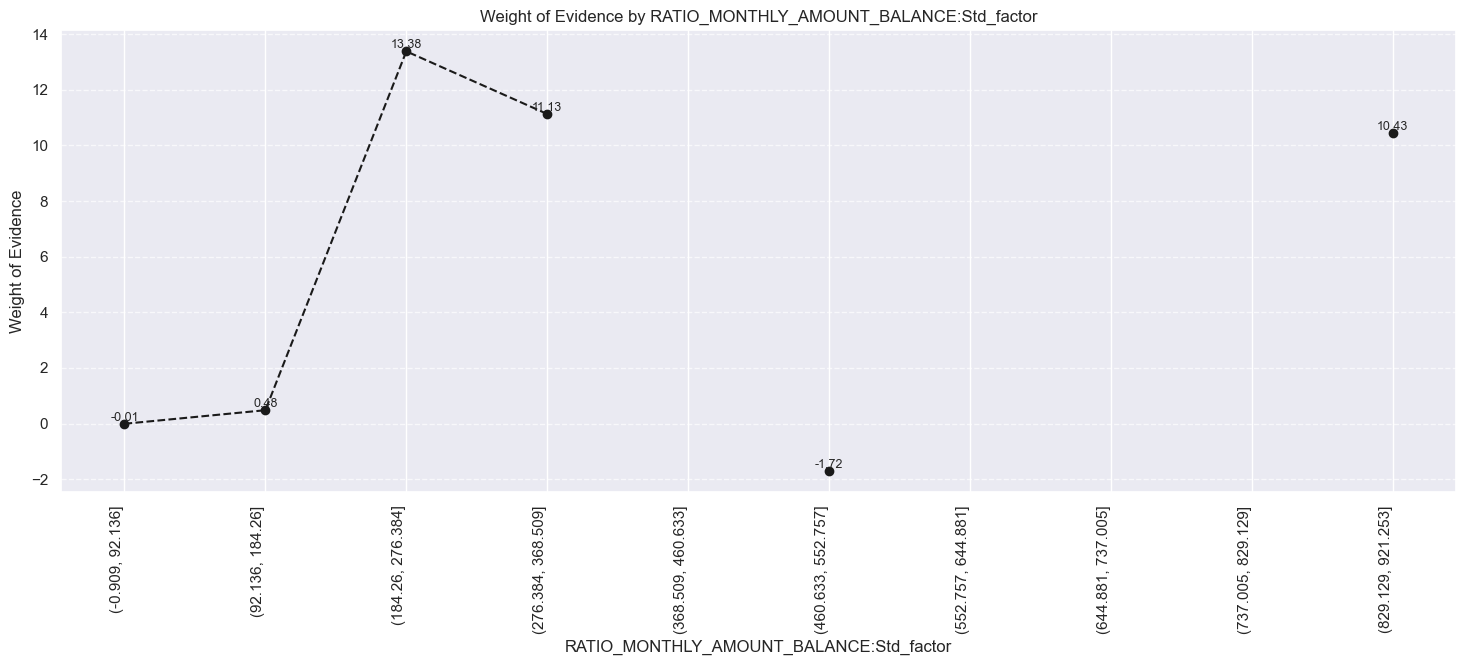

In [73]:
plot_by_woe(df_temp, 90)

In [74]:
df_inputs_prepr['RATIO_MONTHLY_AMOUNT_BALANCE:Std:<92.136'] = np.where(df_inputs_prepr['RATIO_MONTHLY_AMOUNT_BALANCE:Std'] <= 92.136, 1, 0)
df_inputs_prepr['RATIO_MONTHLY_AMOUNT_BALANCE:Std:92.136-461'] = np.where((df_inputs_prepr['RATIO_MONTHLY_AMOUNT_BALANCE:Std'] > 92.136) & (df_inputs_prepr['RATIO_AMOUNT_BALANCE:Std'] <= 461) , 1, 0)
df_inputs_prepr['RATIO_MONTHLY_AMOUNT_BALANCE:Std:>461'] = np.where(df_inputs_prepr['RATIO_MONTHLY_AMOUNT_BALANCE:Std'] > 461, 1, 0)

In [75]:
df_inputs_prepr['RATIO_YEARLY_AMOUNT_BALANCE:Std_factor'] =pd.cut(df_inputs_prepr['RATIO_YEARLY_AMOUNT_BALANCE:Std'], 10) # we do fine classing here in 50 buckets
df_temp = woe_ordered_continuous(df_inputs_prepr, 'RATIO_YEARLY_AMOUNT_BALANCE:Std_factor', df_targets_prepr)
df_temp

,RATIO_YEARLY_AMOUNT_BALANCE:Std_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-1.599, 184.581]",3422,0.846873,0.985315,2898.0,524.0,0.984375,0.990548,-0.006252,NaN,NaN,0.065369
1,"(184.581, 368.917]",38,0.921053,0.010942,35.0,3.0,0.011889,0.005671,0.740199,0.074179,0.746450,0.065369
2,"(368.917, 553.253]",7,1.000000,0.002016,7.0,0.0,0.002378,0.000000,12.379071,0.078947,11.638872,0.065369
3,"(553.253, 737.589]",3,0.666667,0.000864,2.0,1.0,0.000679,0.001890,-1.023379,0.333333,13.402450,0.065369
4,"(737.589, 921.925]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.065369
5,"(921.925, 1106.261]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.065369
6,"(1106.261, 1290.598]",1,1.000000,0.000288,1.0,0.0,0.000340,0.000000,10.433186,NaN,NaN,0.065369
7,"(1290.598, 1474.934]",1,0.000000,0.000288,0.0,1.0,0.000000,0.001890,-12.149698,1.000000,22.582883,0.065369
8,"(1474.934, 1659.27]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.065369
9,"(1659.27, 1843.606]",1,1.000000,0.000288,1.0,0.0,0.000340,0.000000,10.433186,NaN,NaN,0.065369


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


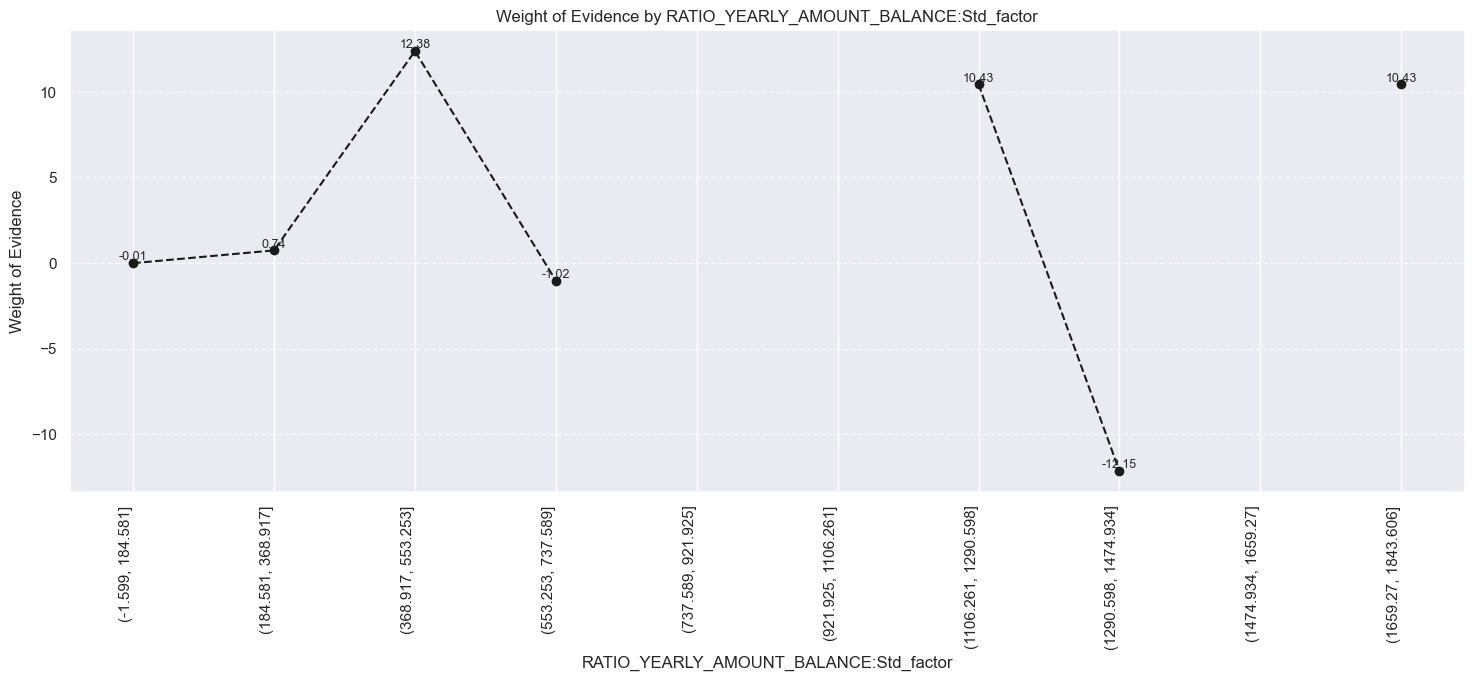

In [76]:
plot_by_woe(df_temp, 90)

In [77]:
df_inputs_prepr['RATIO_YEARLY_AMOUNT_BALANCE:Std:<184.581'] = np.where(df_inputs_prepr['RATIO_YEARLY_AMOUNT_BALANCE:Std'] <= 184.581, 1, 0)
df_inputs_prepr['RATIO_YEARLY_AMOUNT_BALANCE:Std:>184.581'] = np.where(df_inputs_prepr['RATIO_YEARLY_AMOUNT_BALANCE:Std'] > 184.581, 1, 0)

In [78]:
df_inputs_prepr['RATIO_YEARLY_AMOUNT_BALANCE:mean_factor'] =pd.cut(df_inputs_prepr['RATIO_YEARLY_AMOUNT_BALANCE:mean'], 10) # we do fine classing here in 50 buckets
df_temp = woe_ordered_continuous(df_inputs_prepr, 'RATIO_YEARLY_AMOUNT_BALANCE:mean_factor', df_targets_prepr)
df_temp

,RATIO_YEARLY_AMOUNT_BALANCE:mean_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(0.0432, 0.457]",3104,0.846327,0.893752,2627.0,477.0,0.892323,0.901701,-0.010455,NaN,NaN,0.028765
1,"(0.457, 0.868]",251,0.888446,0.072272,223.0,28.0,0.075747,0.052930,0.358431,0.042119,0.368886,0.028765
2,"(0.868, 1.278]",114,0.789474,0.032825,90.0,24.0,0.030571,0.045369,-0.394780,0.098973,0.753211,0.028765
3,"(1.278, 1.688]",2,1.000000,0.000576,2.0,0.0,0.000679,0.000000,11.126318,0.210526,11.521098,0.028765
4,"(1.688, 2.098]",1,1.000000,0.000288,1.0,0.0,0.000340,0.000000,10.433186,0.000000,0.693132,0.028765
5,"(2.098, 2.508]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.028765
6,"(2.508, 2.918]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.028765
7,"(2.918, 3.328]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.028765
8,"(3.328, 3.738]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.028765
9,"(3.738, 4.149]",1,1.000000,0.000288,1.0,0.0,0.000340,0.000000,10.433186,NaN,NaN,0.028765


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


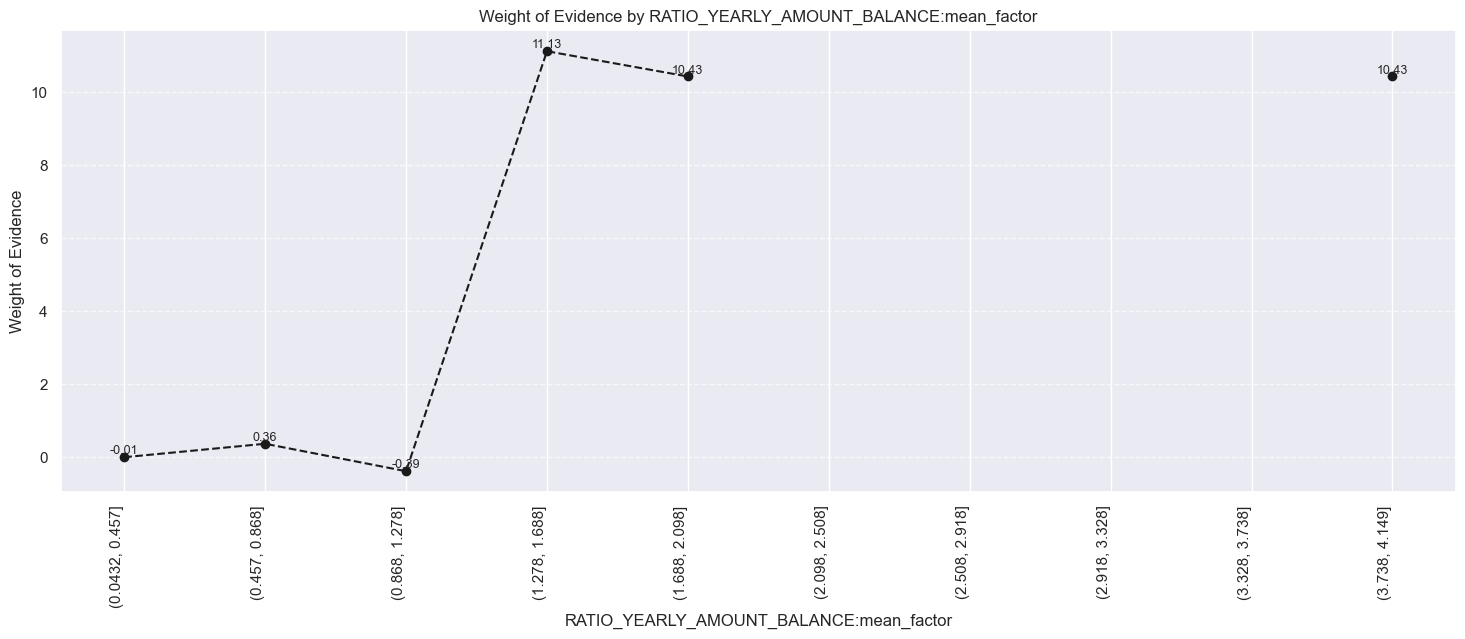

In [79]:
plot_by_woe(df_temp, 90)

In [80]:
df_inputs_prepr['RATIO_YEARLY_AMOUNT_BALANCE:mean:<0.457'] = np.where(df_inputs_prepr['RATIO_YEARLY_AMOUNT_BALANCE:mean'] <= 0.457, 1, 0)
df_inputs_prepr['RATIO_YEARLY_AMOUNT_BALANCE:mean:0.457-1.278'] = np.where((df_inputs_prepr['RATIO_YEARLY_AMOUNT_BALANCE:mean'] > 0.457) & (df_inputs_prepr['RATIO_YEARLY_AMOUNT_BALANCE:mean'] <= 1.278), 1, 0)
df_inputs_prepr['RATIO_YEARLY_AMOUNT_BALANCE:mean:+1.278'] = np.where(df_inputs_prepr['RATIO_YEARLY_AMOUNT_BALANCE:mean'] > 1.278, 1, 0)

In [81]:
df_inputs_prepr['UNEMP_96_factor'] =pd.cut(df_inputs_prepr['UNEMP_96'], 20) # we do fine classing here in 50 buckets
df_temp = woe_ordered_continuous(df_inputs_prepr, 'UNEMP_96_factor', df_targets_prepr)
df_temp

,UNEMP_96_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(0.421, 0.879]",495,0.856566,0.142528,424.0,71.0,0.144022,0.134216,0.070518,NaN,NaN,0.039047
1,"(0.879, 1.327]",112,0.901786,0.032249,101.0,11.0,0.034307,0.020794,0.500689,0.045220,0.430171,0.039047
2,"(1.327, 1.775]",117,0.846154,0.033688,99.0,18.0,0.033628,0.034026,-0.011788,0.055632,0.512477,0.039047
3,"(1.775, 2.224]",352,0.823864,0.101353,290.0,62.0,0.098505,0.117202,-0.173789,0.022290,0.162002,0.039047
4,"(2.224, 2.673]",332,0.846386,0.095595,281.0,51.0,0.095448,0.096408,-0.010007,0.022522,0.163782,0.039047
5,"(2.673, 3.121]",203,0.891626,0.058451,181.0,22.0,0.061481,0.041588,0.390918,0.045240,0.400925,0.039047
6,"(3.121, 3.57]",231,0.813853,0.066513,188.0,43.0,0.063859,0.081285,-0.241294,0.077773,0.632213,0.039047
7,"(3.57, 4.018]",319,0.833856,0.091851,266.0,53.0,0.090353,0.100189,-0.103332,0.020003,0.137963,0.039047
8,"(4.018, 4.466]",236,0.822034,0.067953,194.0,42.0,0.065897,0.079395,-0.186347,0.011822,0.083016,0.039047
9,"(4.466, 4.915]",270,0.822222,0.077743,222.0,48.0,0.075408,0.090737,-0.185060,0.000188,0.001288,0.039047


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


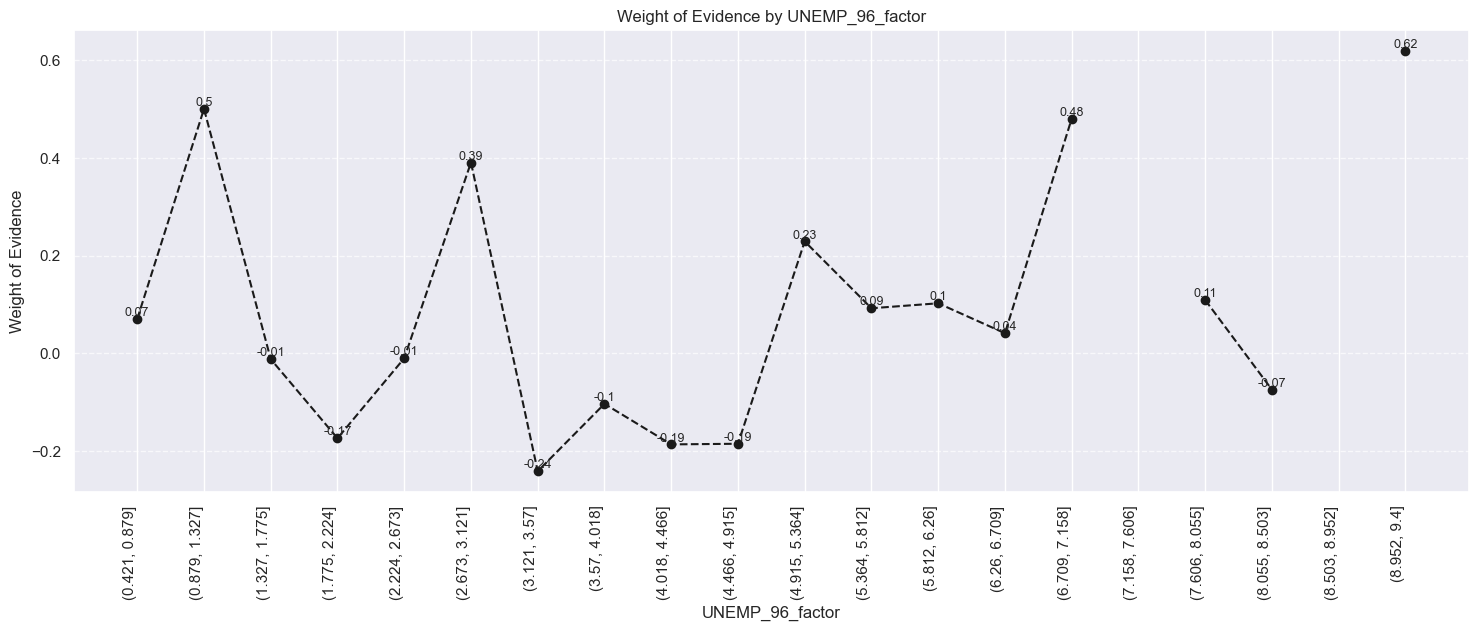

In [82]:
plot_by_woe(df_temp, 90)

In [83]:
df_inputs_prepr['UNEMP_96:<1.327'] = np.where(df_inputs_prepr['UNEMP_96'] <= 1.327, 1, 0)
df_inputs_prepr['UNEMP_96:1.327-2.673'] = np.where((df_inputs_prepr['UNEMP_96'] > 1.327) & (df_inputs_prepr['UNEMP_96'] <= 2.673), 1, 0)
df_inputs_prepr['UNEMP_96:2.673-3.121'] = np.where((df_inputs_prepr['UNEMP_96'] > 2.673) & (df_inputs_prepr['UNEMP_96'] <= 3.121), 1, 0)
df_inputs_prepr['UNEMP_96:3.121-4.915'] = np.where((df_inputs_prepr['UNEMP_96'] > 3.121) & (df_inputs_prepr['UNEMP_96'] <= 4.915), 1, 0)
df_inputs_prepr['UNEMP_96:4.915-6.709'] = np.where((df_inputs_prepr['UNEMP_96'] > 4.915) & (df_inputs_prepr['UNEMP_96'] <= 6.709), 1, 0)
df_inputs_prepr['UNEMP_96:+6.709'] = np.where(df_inputs_prepr['UNEMP_96'] > 6.709, 1, 0)

### Preprocessing the test dataset

In [ ]:
#####
loan_data_inputs_train = df_inputs_prepr
#####
# loan_data_inputs_test = df_inputs_prepr
######

In [ ]:
category_columns = loan_data_inputs_train.select_dtypes(include=['category']).columns
loan_data_inputs_train = loan_data_inputs_train.drop(columns=category_columns)

In [ ]:
category_columns = loan_data_inputs_test.select_dtypes(include=['category']).columns
loan_data_inputs_test = loan_data_inputs_test.drop(columns=category_columns)

In [ ]:
# loan_data_inputs_train.to_csv('./data/loan_data_inputs_train.csv')
# loan_data_targets_train.to_csv('./data/loan_data_targets_train.csv')
# loan_data_inputs_test.to_csv('./data/loan_data_inputs_test.csv')
# loan_data_targets_test.to_csv('./data/loan_data_targets_test.csv')

# 4. Modelling Probability of Default

We will use the bad/good Target observed variable to assess the probability a customer defaults. We will use a model easy to understand a interpret, so final stakeholders can effectively use the model.

The logistic regression predicts the probability of an event ocurring based on the input data. The regression is defined by a logistic function (sigmoid function) that serves as a link function for the expected conditional probability the output binary independent variable. 

We are predicting the probability of non-default (good customer) so higher probabilities and the sign of the coefficients will be more interpretable and there won't be room for confusion. 

The independent variables of our model are dummy variables. The reason for that is that the coefficient of the model shows the exact difference in term of logodds units for an observation when the dummy variable == 1 and the observation when the dummy variable == 0, and that's pretty much what we do with credit scorecards. We analyse how many scores has a customer when belonging to a particular category.


In [2]:
loan_data_inputs_train = pd.read_csv('./data/loan_data_inputs_train.csv', index_col = [0, 1])
loan_data_targets_train = pd.read_csv('./data/loan_data_targets_train.csv', index_col = [0, 1])
loan_data_inputs_test = pd.read_csv('./data/loan_data_inputs_test.csv', index_col = [0, 1])
loan_data_targets_test = pd.read_csv('./data/loan_data_targets_test.csv', index_col = [0, 1])

### Selecting the Features and dropping reference categories

In [3]:
# Here we select a limited set of input variables in a new dataframe.
inputs_train_with_ref_cat = loan_data_inputs_train.loc[: , [
    'GENDER:M',
    'GENDER:F',
    'MOST_COMMON_TRANS_OPERATION:OTHER_CREDIT_IN_CASH_COLLECTION_FROM_OTHER_BANK',
    'MOST_COMMON_TRANS_OPERATION:WITHDRAWAL_IN_CASH',
    'MOST_COMMON_TRANS_OPERATION:REMITTANCE_TO_OTHER_BANK',
    'AGE:18-22',
    'AGE:22-27',
    'AGE:27-34',
    'AGE:34-43',
    'AGE:44-57',
    'AGE:58-63',
    'AGE:64-75',
    'AGE:75+',
    'AMOUNT:Count:<49',
    'AMOUNT:Count:50-90',
    'AMOUNT:Count:90-248',
    'AMOUNT:Count:248-301',
    'AMOUNT:Count:301-340',
    'AMOUNT:Count:340-394',
    'AMOUNT:Count:394-433',
    'AMOUNT:Count:433-566',
    'AMOUNT:Count:+566',
    'AMOUNT:<6281',
    'AMOUNT:6281-24871',
    'AMOUNT:24871-40081',
    'AMOUNT:40081-45150',
    'AMOUNT:45150-50220',
    'AMOUNT:50220-70500',
    'AMOUNT:+70500',
    'AVG_SALARY:<8332',
    'AVG_SALARY:8332-9440',
    'AVG_SALARY:9440-9661',
    'AVG_SALARY:9661-9882',
    'AVG_SALARY:9882-10104',
    'AVG_SALARY:10104-12320',
    'AVG_SALARY:+12320',
    'RATIO_AMOUNT_BALANCE:Std:<0.117',
    'RATIO_AMOUNT_BALANCE:Std:0.117-0.443',
    'RATIO_AMOUNT_BALANCE:Std:0.443-0.824',
    'RATIO_AMOUNT_BALANCE:Std:0.824-0.993',
    'RATIO_AMOUNT_BALANCE:Std:+0.993',
    'RATIO_MONTHLY_AMOUNT_BALANCE:Std:<92.136',
    'RATIO_MONTHLY_AMOUNT_BALANCE:Std:92.136-461',
    'RATIO_MONTHLY_AMOUNT_BALANCE:Std:>461',
    'RATIO_YEARLY_AMOUNT_BALANCE:Std:<184.581',
    'RATIO_YEARLY_AMOUNT_BALANCE:Std:>184.581',
    'RATIO_YEARLY_AMOUNT_BALANCE:mean:<0.457',
    'RATIO_YEARLY_AMOUNT_BALANCE:mean:0.457-1.278',
    'RATIO_YEARLY_AMOUNT_BALANCE:mean:+1.278',
    'UNEMP_96:<1.327',
    'UNEMP_96:1.327-2.673',
    'UNEMP_96:2.673-3.121',
    'UNEMP_96:3.121-4.915',
    'UNEMP_96:4.915-6.709',
    'UNEMP_96:+6.709',

]]

In [4]:
# Here we store the names of the reference category dummy variables in a list.
ref_categories = [
    'GENDER:M',
    'MOST_COMMON_TRANS_OPERATION:REMITTANCE_TO_OTHER_BANK',
    'AGE:18-22',
    'AMOUNT:Count:+566',
    'AMOUNT:+70500',
    'AVG_SALARY:9882-10104',
    'RATIO_AMOUNT_BALANCE:Std:0.443-0.824',
    'RATIO_MONTHLY_AMOUNT_BALANCE:Std:<92.136',
    'RATIO_YEARLY_AMOUNT_BALANCE:Std:>184.581',
    'RATIO_YEARLY_AMOUNT_BALANCE:mean:+1.278',
    'UNEMP_96:3.121-4.915',

]

In [5]:
inputs_train = inputs_train_with_ref_cat.drop(ref_categories, axis = 1)
# From the dataframe with input variables, we drop the variables with variable names in the list with reference categories. 
inputs_train.head()

GENDER:F  \
SET_SPLIT CLIENT_ID             
TRAIN     1                 1   
          2                 0   
          7                 0   
          8                 1   
          9                 0   

                     MOST_COMMON_TRANS_OPERATION:OTHER_CREDIT_IN_CASH_COLLECTION_FROM_OTHER_BANK  \
SET_SPLIT CLIENT_ID                                                                                
TRAIN     1                                                          0                             
          2                                                          0                             
          7                                                          0                             
          8                                                          0                             
          9                                                          0                             

                     MOST_COMMON_TRANS_OPERATION:WITHDRAWAL_IN_CASH  \
SET_SPLIT CLIENT_ID                                                   
TRAIN     1                                                       1   
          2                                                       1   
          7                                                       1   
          8                                                       1   
          9                                                       1   

                     AGE:22-27  AGE:27-34  AGE:34-43  AGE:44-57  AGE:58-63  \
SET_SPLIT CLIENT_ID                                                          
TRAIN     1                  0          1          0          0          0   
          2                  0          0          0          1          0   
          7                  0          0          0          0          0   
          8                  0          0          0          0          1   
          9                  0          0          0          0          1   

                     AGE:64-75  AGE:75+  AMOUNT:Count:<49  AMOUNT:Count:50-90  \
SET_SPLIT CLIENT_ID                                                             
TRAIN     1                  0        0                 0                   0   
          2                  0        0                 0                   0   
          7                  1        0                 0                   1   
          8                  0        0                 0                   0   
          9                  0        0                 0                   0   

                     AMOUNT:Count:90-248  AMOUNT:Count:248-301  \
SET_SPLIT CLIENT_ID                                              
TRAIN     1                            1                     0   
          2                            0                     0   
          7                            0                     0   
          8                            1                     0   
          9                            1                     0   

                     AMOUNT:Count:301-340  AMOUNT:Count:340-394  \
SET_SPLIT CLIENT_ID                                               
TRAIN     1                             0                     0   
          2                             0                     0   
          7                             0                     0   
          8                             0                     0   
          9                             0                     0   

                     AMOUNT:Count:394-433  AMOUNT:Count:433-566  AMOUNT:<6281  \
SET_SPLIT CLIENT_ID                                                             
TRAIN     1                             0                     0             0   
          2                             0                     1             0   
          7                             0                     0             1   
          8                             0                     0             0   
          9                             0               

## 4.1 Train initial model - Logistic Regression

The default **LogisticRegression** class in scikit learn does not have a method for calculating p-values. Although there are some functions out there they are univariate, meaning that they take into consideration the impact of each feature in the outcome as if there were no other features. In regression analysis however, the impact is collective rather than independent. Thus, the inside from such methods would not the reliable. 

We will create a new logistic regression class that inherits the methods from the scikit learn **LogisticRegression** class, but we will create a new method to calculate the multivariable p-values based on the 



In [6]:
# P values for sklearn logistic regression.
# Reference: https://gist.github.com/rspeare/77061e6e317896be29c6de9a85db301d

# Class to display p-values for logistic regression in sklearn.

class LogisticRegression_with_p_values:
    
    def __init__(self,*args,**kwargs):#,**kwargs):
        self.model = LogisticRegression(*args,**kwargs)#,**args)

    def fit(self,X,y):
        self.model.fit(X,y)
        
        #### Get p-values for the fitted model ####
        denom = (2.0 * (1.0 + np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X / denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0] / sigma_estimates # z-score for eaach model coefficient
        p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores] ### two tailed test for p-values
        
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        self.p_values = p_values

In [7]:
pd.options.display.max_rows = None
# Sets the pandas dataframe options to display all columns/ rows.

reg = LogisticRegression_with_p_values()
reg.fit(inputs_train, np.ravel(loan_data_targets_train))

## 4.2 Select statistically significant features

In [8]:
feature_name = inputs_train.columns.values
# Stores the names of the columns of a dataframe in a variable.
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg.intercept_[0]]
summary_table = summary_table.sort_index()

p_values = reg.p_values
# We take the result of the newly added method 'p_values' and store it in a variable 'p_values'.
# Add the intercept for completeness.
p_values = np.append(np.nan, np.array(p_values))
# We add the value 'NaN' in the beginning of the variable with p-values.
summary_table['p_values'] = p_values
# In the 'summary_table' dataframe, we add a new column, called 'p_values', containing the values from the 'p_values' variable.
summary_table

,Feature name,Coefficients,p_values
0,Intercept,1.029831,NaN
1,GENDER:F,-0.039583,0.703066
2,MOST_COMMON_TRANS_OPERATION:OTHER_CREDIT_IN_CA...,1.078419,0.046132
3,MOST_COMMON_TRANS_OPERATION:WITHDRAWAL_IN_CASH,0.518502,0.000659
4,AGE:22-27,-0.416239,0.062612
5,AGE:27-34,-0.525047,0.009979
6,AGE:34-43,-0.401542,0.039694
7,AGE:44-57,-0.191899,0.300806
8,AGE:58-63,-0.571585,0.010620
9,AGE:64-75,2.236240,0.001417


Based on the output table above, we observed the p-values for each variable in the logistic regression model. A p-value represents the probability of obtaining results as extreme as the ones observed, assuming that the variable's coefficient is zero (i.e., the variable has no effect on the outcome).

In light of statistical significance, we made the decision to remove the variables for which any of the class dummy variables were not statistically significant, meaning they had a p-value above 0.05. By doing so, we aimed to create a more refined and accurate final model, focusing only on the variables that have a substantial impact on the outcome.

After eliminating these non-significant variables, we proceeded to re-train the logistic regression model with only the remaining statistically significant variables. This final model is expected to better capture the underlying relationships between the predictors and the target variable, leading to improved predictions and a more interpretable model.

The exclusion of non-significant variables ensures that we prioritize meaningful features and reduce the risk of overfitting, which can occur when including irrelevant predictors. By employing this rigorous approach, we aim to achieve a more robust and reliable logistic regression model for making informed predictions and drawing valuable insights from the data.

## 4.3 Train final model - Logistic Regression

In [9]:
# Here we select a limited set of input variables in a new dataframe.
input_vars = [
    'MOST_COMMON_TRANS_OPERATION:OTHER_CREDIT_IN_CASH_COLLECTION_FROM_OTHER_BANK',
    'MOST_COMMON_TRANS_OPERATION:WITHDRAWAL_IN_CASH',
    'MOST_COMMON_TRANS_OPERATION:REMITTANCE_TO_OTHER_BANK',
    'AGE:18-22',
    'AGE:22-27',
    'AGE:27-34',
    'AGE:34-43',
    'AGE:44-57',
    'AGE:58-63',
    'AGE:64-75',
    'AGE:75+',
    'AMOUNT:Count:<49',
    'AMOUNT:Count:50-90',
    'AMOUNT:Count:90-248',
    'AMOUNT:Count:248-301',
    'AMOUNT:Count:301-340',
    'AMOUNT:Count:340-394',
    'AMOUNT:Count:394-433',
    'AMOUNT:Count:433-566',
    'AMOUNT:Count:+566',
    'AMOUNT:<6281',
    'AMOUNT:6281-24871',
    'AMOUNT:24871-40081',
    'AMOUNT:40081-45150',
    'AMOUNT:45150-50220',
    'AMOUNT:50220-70500',
    'AMOUNT:+70500',
    'UNEMP_96:<1.327',
    'UNEMP_96:1.327-2.673',
    'UNEMP_96:2.673-3.121',
    'UNEMP_96:3.121-4.915',
    'UNEMP_96:4.915-6.709',
    'UNEMP_96:+6.709',

]

# Here we store the names of the reference category dummy variables in a list.
ref_categories = [
    'MOST_COMMON_TRANS_OPERATION:REMITTANCE_TO_OTHER_BANK',
    'AGE:18-22',
    'AMOUNT:Count:+566',
    'AMOUNT:+70500',
    'UNEMP_96:3.121-4.915',
]

inputs_train_with_ref_cat = loan_data_inputs_train.loc[: , input_vars]

In [10]:
inputs_train = inputs_train_with_ref_cat.drop(ref_categories, axis = 1)
inputs_train.head()

MOST_COMMON_TRANS_OPERATION:OTHER_CREDIT_IN_CASH_COLLECTION_FROM_OTHER_BANK  \
SET_SPLIT CLIENT_ID                                                                                
TRAIN     1                                                          0                             
          2                                                          0                             
          7                                                          0                             
          8                                                          0                             
          9                                                          0                             

                     MOST_COMMON_TRANS_OPERATION:WITHDRAWAL_IN_CASH  \
SET_SPLIT CLIENT_ID                                                   
TRAIN     1                                                       1   
          2                                                       1   
          7                                                       1   
          8                                                       1   
          9                                                       1   

                     AGE:22-27  AGE:27-34  AGE:34-43  AGE:44-57  AGE:58-63  \
SET_SPLIT CLIENT_ID                                                          
TRAIN     1                  0          1          0          0          0   
          2                  0          0          0          1          0   
          7                  0          0          0          0          0   
          8                  0          0          0          0          1   
          9                  0          0          0          0          1   

                     AGE:64-75  AGE:75+  AMOUNT:Count:<49  AMOUNT:Count:50-90  \
SET_SPLIT CLIENT_ID                                                             
TRAIN     1                  0        0                 0                   0   
          2                  0        0                 0                   0   
          7                  1        0                 0                   1   
          8                  0        0                 0                   0   
          9                  0        0                 0                   0   

                     AMOUNT:Count:90-248  AMOUNT:Count:248-301  \
SET_SPLIT CLIENT_ID                                              
TRAIN     1                            1                     0   
          2                            0                     0   
          7                            0                     0   
          8                            1                     0   
          9                            1                     0   

                     AMOUNT:Count:301-340  AMOUNT:Count:340-394  \
SET_SPLIT CLIENT_ID                                               
TRAIN     1                             0                     0   
          2                             0                     0   
          7                             0                     0   
          8                             0                     0   
          9                             0                     0   

                     AMOUNT:Count:394-433  AMOUNT:Count:433-566  AMOUNT:<6281  \
SET_SPLIT CLIENT_ID                                                             
TRAIN     1                             0                     0             0   
          2                             0                     1             0   
          7                             0                     0             1   
          8                             0                     0             0   
          9                             0                     0             0   

                     AMOUNT:6281-24871  AMOUNT:24871-40081  \
SET_SPLIT CLIENT_ID                                          
TRAIN     1                          1                   0   
          2         

In [11]:
# Here we run a new model.
reg2 = LogisticRegression_with_p_values(max_iter=500)
reg2.fit(inputs_train, np.ravel(loan_data_targets_train))
feature_name = inputs_train.columns.values

# Same as above.
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg2.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg2.intercept_[0]]
p_values = reg2.p_values
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values
summary_table
summary_table = summary_table.sort_index()
summary_table

,Feature name,Coefficients,p_values
0,Intercept,0.782708,3.469638e-02
1,MOST_COMMON_TRANS_OPERATION:OTHER_CREDIT_IN_CA...,1.143962,NaN
2,MOST_COMMON_TRANS_OPERATION:WITHDRAWAL_IN_CASH,0.516789,3.209687e-02
3,AGE:22-27,-0.397266,6.280422e-04
4,AGE:27-34,-0.516273,6.652717e-02
5,AGE:34-43,-0.401248,8.534108e-03
6,AGE:44-57,-0.180161,3.290872e-02
7,AGE:58-63,-0.554133,3.128976e-01
8,AGE:64-75,2.206600,9.964587e-03
9,AGE:75+,1.567157,1.656139e-03


In [12]:
# pickle.dump(reg2, open('logistic_reg_model.sav', 'wb'))

# 5. PD Model Validation (Test)

In [13]:
# Here we select a limited set of input variables in a new dataframe.
inputs_test_with_ref_cat = loan_data_inputs_test.loc[: , input_vars]
inputs_test = inputs_test_with_ref_cat.drop(ref_categories, axis = 1)
inputs_test.head()

MOST_COMMON_TRANS_OPERATION:OTHER_CREDIT_IN_CASH_COLLECTION_FROM_OTHER_BANK  \
SET_SPLIT CLIENT_ID                                                                                
TEST      4                                                          0                             
          19                                                         0                             
          38                                                         0                             
          44                                                         0                             
          48                                                         0                             

                     MOST_COMMON_TRANS_OPERATION:WITHDRAWAL_IN_CASH  \
SET_SPLIT CLIENT_ID                                                   
TEST      4                                                       0   
          19                                                      1   
          38                                                      1   
          44                                                      1   
          48                                                      1   

                     AGE:22-27  AGE:27-34  AGE:34-43  AGE:44-57  AGE:58-63  \
SET_SPLIT CLIENT_ID                                                          
TEST      4                  0          0          1          0          0   
          19                 0          0          0          1          0   
          38                 1          0          0          0          0   
          44                 0          0          0          0          0   
          48                 0          0          0          0          1   

                     AGE:64-75  AGE:75+  AMOUNT:Count:<49  AMOUNT:Count:50-90  \
SET_SPLIT CLIENT_ID                                                             
TEST      4                  0        0                 0                   0   
          19                 0        0                 0                   0   
          38                 0        0                 0                   0   
          44                 0        0                 0                   0   
          48                 0        0                 0                   0   

                     AMOUNT:Count:90-248  AMOUNT:Count:248-301  \
SET_SPLIT CLIENT_ID                                              
TEST      4                            1                     0   
          19                           1                     0   
          38                           0                     1   
          44                           0                     0   
          48                           0                     0   

                     AMOUNT:Count:301-340  AMOUNT:Count:340-394  \
SET_SPLIT CLIENT_ID                                               
TEST      4                             0                     0   
          19                            0                     0   
          38                            0                     0   
          44                            0                     1   
          48                            0                     1   

                     AMOUNT:Count:394-433  AMOUNT:Count:433-566  AMOUNT:<6281  \
SET_SPLIT CLIENT_ID                                                             
TEST      4                             0                     0             0   
          19                            0                     0             0   
          38                            0                     0             0   
          44                            0                     0             0   
          48                            0                     0             0   

                     AMOUNT:6281-24871  AMOUNT:24871-40081  \
SET_SPLIT CLIENT_ID                                          
TEST      4                          1                   0   
          19        

In [14]:
y_hat_test = reg2.model.predict(inputs_test)
y_hat_test_proba = reg2.model.predict_proba(inputs_test)
y_hat_test_proba = y_hat_test_proba[: ][: , 1]

In [15]:
loan_data_targets_test_temp = loan_data_targets_test
loan_data_targets_test_temp = loan_data_targets_test_temp.reset_index(drop = True)
df_actual_predicted_probs = pd.concat([loan_data_targets_test_temp, pd.DataFrame(y_hat_test_proba)], axis = 1)

df_actual_predicted_probs.columns = ['loan_data_targets_test', 'y_hat_test_proba']
df_actual_predicted_probs.index = loan_data_inputs_test.index
df_actual_predicted_probs.head()

loan_data_targets_test  y_hat_test_proba
SET_SPLIT CLIENT_ID                                          
TEST      4                               1          0.804534
          19                              1          0.900989
          38                              1          0.751662
          44                              1          0.927296
          48                              1          0.904731

## 5.1 Area under the ROC cuve

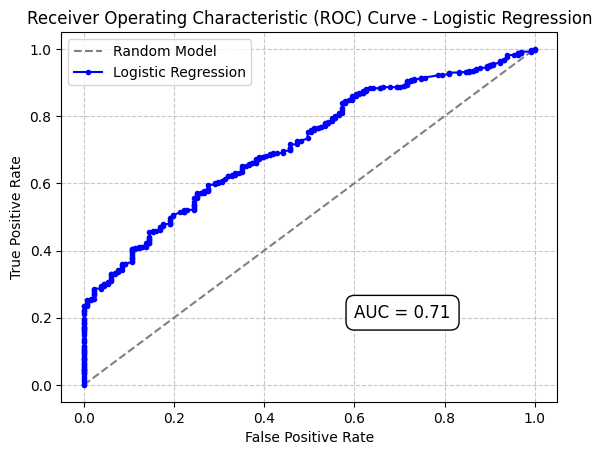

In [16]:
lr_auc = metrics.roc_auc_score(df_actual_predicted_probs['loan_data_targets_test'].values, df_actual_predicted_probs['y_hat_test_proba'].values)

fpr, tpr, thresholds = metrics.roc_curve(df_actual_predicted_probs['loan_data_targets_test'].values, df_actual_predicted_probs['y_hat_test_proba'].values)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Model')
plt.plot(fpr, tpr, marker='.', label='Logistic Regression', color='blue')

plt.text(0.6, 0.2, f'AUC = {lr_auc:.2f}', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Receiver Operating Characteristic (ROC) Curve - Logistic Regression')

plt.grid(True, linestyle='--', alpha=0.7)

plt.legend()
plt.show()


## 5.2 Finding the best threshold for classification

In [17]:
# Reference: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
best_threshold = thresholds[ix]
g_means = gmeans[ix]
print(f'Best Threshold = {best_threshold}, G-Mean = {g_means}')

Best Threshold = 0.8612237712115532, G-Mean = 0.6563510672232766


In [18]:
df_actual_predicted_probs['y_hat_test'] = np.where(df_actual_predicted_probs['y_hat_test_proba'] > best_threshold, 1, 0)
df_actual_predicted_probs.head()


loan_data_targets_test  y_hat_test_proba  y_hat_test
SET_SPLIT CLIENT_ID                                                      
TEST      4                               1          0.804534           0
          19                              1          0.900989           1
          38                              1          0.751662           0
          44                              1          0.927296           1
          48                              1          0.904731           1

## 5.3 Accuracy and Misclassification Rate

In [19]:
# Calculate Accuracy
accuracy = metrics.accuracy_score(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'])

# Calculate Misclassification Rate
misclassification_rate = 1 - accuracy

print("Accuracy:", accuracy)
print("Misclassification Rate:", misclassification_rate)

Accuracy: 0.6057471264367816
Misclassification Rate: 0.39425287356321836


## 5.4 Gini and Kolmogorov-Smirnov

In [20]:
df_actual_predicted_probs = df_actual_predicted_probs.sort_values('y_hat_test_proba')
df_actual_predicted_probs = df_actual_predicted_probs.reset_index()

df_actual_predicted_probs['Cumulative N Population'] = df_actual_predicted_probs.index + 1
# We calculate the cumulative number of all observations.
# We use the new index for that. Since indexing in ython starts from 0, we add 1 to each index.
df_actual_predicted_probs['Cumulative N Good'] = df_actual_predicted_probs['loan_data_targets_test'].cumsum()
# We calculate cumulative number of 'good', which is the cumulative sum of the column with actual observations.
df_actual_predicted_probs['Cumulative N Bad'] = df_actual_predicted_probs['Cumulative N Population'] - df_actual_predicted_probs['loan_data_targets_test'].cumsum()
# We calculate cumulative number of 'bad', which is
# the difference between the cumulative number of all observations and cumulative number of 'good' for each row.
df_actual_predicted_probs['Cumulative Perc Population'] = df_actual_predicted_probs['Cumulative N Population'] / (df_actual_predicted_probs.shape[0])
# We calculate the cumulative percentage of all observations.
df_actual_predicted_probs['Cumulative Perc Good'] = df_actual_predicted_probs['Cumulative N Good'] / df_actual_predicted_probs['loan_data_targets_test'].sum()
# We calculate cumulative percentage of 'good'.
df_actual_predicted_probs['Cumulative Perc Bad'] = df_actual_predicted_probs['Cumulative N Bad'] / (df_actual_predicted_probs.shape[0] - df_actual_predicted_probs['loan_data_targets_test'].sum())
# We calculate the cumulative percentage of 'bad'.
df_actual_predicted_probs.head()

,SET_SPLIT,CLIENT_ID,loan_data_targets_test,y_hat_test_proba,y_hat_test,Cumulative N Population,Cumulative N Good,Cumulative N Bad,Cumulative Perc Population,Cumulative Perc Good,Cumulative Perc Bad
0,TEST,2932,1,0.392746,0,1,1,0,0.001149,0.001353,0.000000
1,TEST,2216,1,0.439242,0,2,2,0,0.002299,0.002706,0.000000
2,TEST,2390,1,0.447778,0,3,3,0,0.003448,0.004060,0.000000
3,TEST,2698,0,0.448565,0,4,3,1,0.004598,0.004060,0.007634
4,TEST,4658,1,0.453235,0,5,4,1,0.005747,0.005413,0.007634


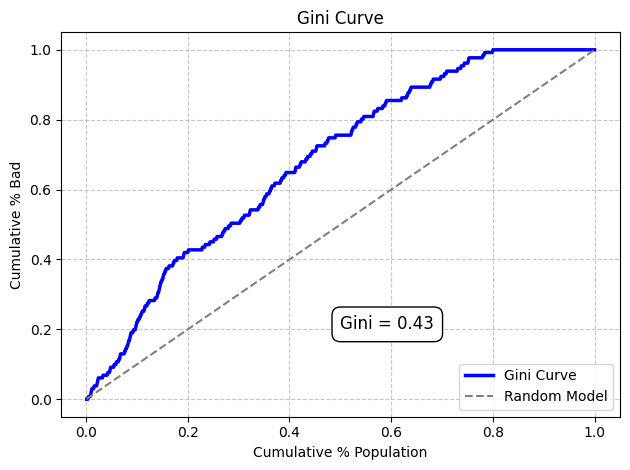

In [21]:
# Calculate Gini
Gini = lr_auc * 2 - 1
# Plot Gini
plt.plot(df_actual_predicted_probs['Cumulative Perc Population'], df_actual_predicted_probs['Cumulative Perc Bad'], color='blue', linewidth=2.5, label='Gini Curve')

plt.plot(df_actual_predicted_probs['Cumulative Perc Population'], df_actual_predicted_probs['Cumulative Perc Population'], linestyle='--', color='gray', label='Random Model')

plt.xlabel('Cumulative % Population')
plt.ylabel('Cumulative % Bad')
plt.title('Gini Curve')

plt.legend(loc='lower right')

plt.grid(True, linestyle='--', alpha=0.7)

plt.text(0.5, 0.2, f'Gini = {Gini:.2f}', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.tight_layout()
plt.show()


KS Statistic = 0.3103448275862069, Statistic p-value = 2.109750667111173e-37


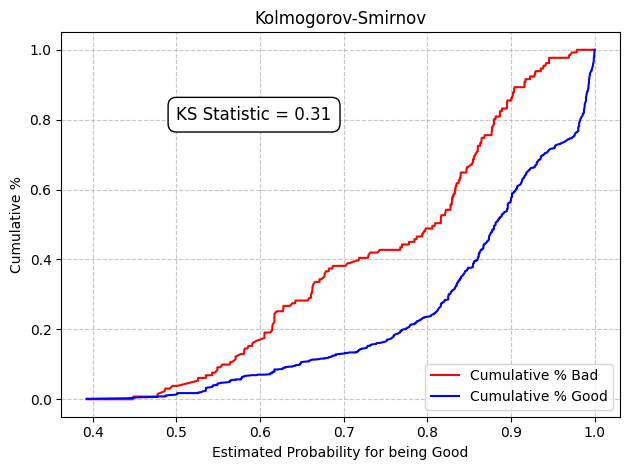

In [22]:
# Details on the calculation of p-value: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html
# Also here: http://archive.ymsc.tsinghua.edu.cn/pacm_download/116/6944-11512_2007_Article_BF02589501.pdf

result = stat.ks_2samp(df_actual_predicted_probs['y_hat_test_proba'], df_actual_predicted_probs['Cumulative Perc Bad'])
ks_statistic = result[0]
ks_pvalue = result[1]
print(f"KS Statistic = {ks_statistic}, Statistic p-value = {ks_pvalue}")

# Plot KS
plt.plot(df_actual_predicted_probs['y_hat_test_proba'], df_actual_predicted_probs['Cumulative Perc Bad'], color='r', label='Cumulative % Bad')
plt.plot(df_actual_predicted_probs['y_hat_test_proba'], df_actual_predicted_probs['Cumulative Perc Good'], color='b', label='Cumulative % Good')
# We plot the predicted (estimated) probabilities along the x-axis and the cumulative percentage 'good' and 'bad' along the y-axis,
# colored in red and blue
plt.xlabel('Estimated Probability for being Good')
plt.ylabel('Cumulative %')
plt.title('Kolmogorov-Smirnov')
plt.text(0.5, 0.8, f'KS Statistic = {ks_statistic:.2f}', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## 6.Scorecard creation

## 6.1 Covert model coefficients into scores

In [23]:
df_ref_categories = pd.DataFrame(ref_categories, columns = ['Feature name'])
# We create a new dataframe with one column. Its values are the values from the 'reference_categories' list.
# We name it 'Feature name'.
df_ref_categories['Coefficients'] = 0
# We create a second column, called 'Coefficients', which contains only 0 values.
df_ref_categories['p_values'] = np.nan

df_scorecard = pd.concat([summary_table, df_ref_categories])
# Concatenates two dataframes.
df_scorecard = df_scorecard.reset_index()
# We reset the index of a dataframe.

df_scorecard['Original feature name'] = df_scorecard['Feature name'].str.split(':').str[0]
# We create a new column, called 'Original feature name', which contains the value of the 'Feature name' column,
# up to the column symbol.

min_score = 300
max_score = 850

df_scorecard.groupby('Original feature name')['Coefficients'].min()
# Groups the data by the values of the 'Original feature name' column.
# Aggregates the data in the 'Coefficients' column, calculating their minimum.

min_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].min().sum()
# Up to the 'min()' method everything is the same as in te line above.
# Then, we aggregate further and sum all the minimum values.
max_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].max().sum()
# Up to the 'min()' method everything is the same as in te line above.
# Then, we aggregate further and sum all the maximum values.
df_scorecard['Score - Calculation'] = df_scorecard['Coefficients'] * (max_score - min_score) / (max_sum_coef - min_sum_coef)
# We multiply the value of the 'Coefficients' column by the ration of the differences between
# maximum score and minimum score and maximum sum of coefficients and minimum sum of cefficients.
df_scorecard['Score - Calculation'][0] = ((df_scorecard['Coefficients'][0] - min_sum_coef) / (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score
# We divide the difference of the value of the 'Coefficients' column and the minimum sum of coefficients by
# the difference of the maximum sum of coefficients and the minimum sum of coefficients.
# Then, we multiply that by the difference between the maximum score and the minimum score.
# Then, we add minimum score. 
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()

In [24]:
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].min().sum()
# Groups the data by the values of the 'Original feature name' column.
# Aggregates the data in the 'Coefficients' column, calculating their minimum.
# Sums all minimum values.
min_sum_score_prel

300.0

In [25]:
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].max().sum()
# Groups the data by the values of the 'Original feature name' column.
# Aggregates the data in the 'Coefficients' column, calculating their maximum.
# Sums all maximum values.
max_sum_score_prel

850.0

In [26]:
df_scorecard['Score - Final'] = df_scorecard['Score - Preliminary']
df_scorecard

,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation,Score - Preliminary,Score - Final
0,0,Intercept,0.782708,3.469638e-02,Intercept,406.212655,406.0,406.0
1,1,MOST_COMMON_TRANS_OPERATION:OTHER_CREDIT_IN_CA...,1.143962,NaN,MOST_COMMON_TRANS_OPERATION,76.222353,76.0,76.0
2,2,MOST_COMMON_TRANS_OPERATION:WITHDRAWAL_IN_CASH,0.516789,3.209687e-02,MOST_COMMON_TRANS_OPERATION,34.433761,34.0,34.0
3,3,AGE:22-27,-0.397266,6.280422e-04,AGE,-26.469915,-26.0,-26.0
4,4,AGE:27-34,-0.516273,6.652717e-02,AGE,-34.399334,-34.0,-34.0
5,5,AGE:34-43,-0.401248,8.534108e-03,AGE,-26.735251,-27.0,-27.0
6,6,AGE:44-57,-0.180161,3.290872e-02,AGE,-12.004134,-12.0,-12.0
7,7,AGE:58-63,-0.554133,3.128976e-01,AGE,-36.921978,-37.0,-37.0
8,8,AGE:64-75,2.206600,9.964587e-03,AGE,147.026085,147.0,147.0
9,9,AGE:75+,1.567157,1.656139e-03,AGE,104.419916,104.0,104.0


### Caclulating Credit Score

In [27]:
inputs_test_with_ref_cat_w_intercept = inputs_test_with_ref_cat

inputs_test_with_ref_cat_w_intercept.insert(0, 'Intercept', 1)
# We insert a column in the dataframe, with an index of 0, that is, in the beginning of the dataframe.
# The name of that column is 'Intercept', and its values are 1s.

inputs_test_with_ref_cat_w_intercept = inputs_test_with_ref_cat_w_intercept[df_scorecard['Feature name'].values]
# Here, from the 'inputs_test_with_ref_cat_w_intercept' dataframe, we keep only the columns with column names,
# exactly equal to the row values of the 'Feature name' column from the 'df_scorecard' dataframe.

scorecard_scores = df_scorecard['Score - Final']

In [28]:
scorecard_scores = scorecard_scores.values.reshape(34, 1)

In [29]:
y_scores = inputs_test_with_ref_cat_w_intercept.dot(scorecard_scores)
# Here we multiply the values of each row of the dataframe by the values of each column of the variable,
# which is an argument of the 'dot' method, and sum them. It's essentially the sum of the products.

In [30]:
credit_score_per_customer = inputs_test.merge(y_scores, on = 'CLIENT_ID', how = 'left')
credit_score_per_customer = credit_score_per_customer.rename(columns={0: 'CREDIT_SCORE'})
credit_score_per_customer.insert(0, 'CREDIT_SCORE', credit_score_per_customer.pop('CREDIT_SCORE'))
credit_score_per_customer.head()

,CREDIT_SCORE,MOST_COMMON_TRANS_OPERATION:OTHER_CREDIT_IN_CASH_COLLECTION_FROM_OTHER_BANK,MOST_COMMON_TRANS_OPERATION:WITHDRAWAL_IN_CASH,AGE:22-27,AGE:27-34,AGE:34-43,AGE:44-57,AGE:58-63,AGE:64-75,AGE:75+,AMOUNT:Count:<49,AMOUNT:Count:50-90,AMOUNT:Count:90-248,AMOUNT:Count:248-301,AMOUNT:Count:301-340,AMOUNT:Count:340-394,AMOUNT:Count:394-433,AMOUNT:Count:433-566,AMOUNT:<6281,AMOUNT:6281-24871,AMOUNT:24871-40081,AMOUNT:40081-45150,AMOUNT:45150-50220,AMOUNT:50220-70500,UNEMP_96:<1.327,UNEMP_96:1.327-2.673,UNEMP_96:2.673-3.121,UNEMP_96:4.915-6.709,UNEMP_96:+6.709
CLIENT_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,447.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
19,500.0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
38,428.0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
44,523.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
48,503.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0


In [51]:
credit_score_per_customer = credit_score_per_customer.reset_index()
temp = credit_score_per_customer[['CLIENT_ID', 'CREDIT_SCORE']].merge(df_actual_predicted_probs[['CLIENT_ID', 'loan_data_targets_test']], on = 'CLIENT_ID', how = 'left')

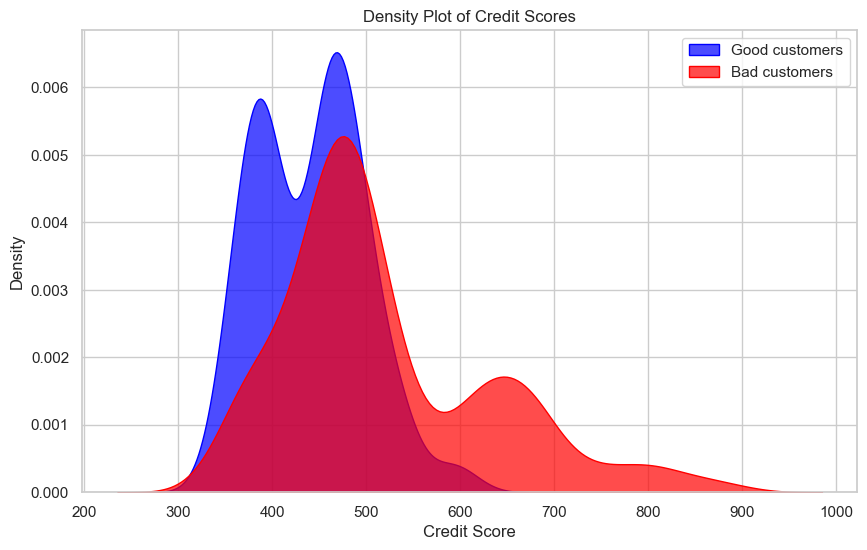

In [55]:
sns.set(style='whitegrid', palette='pastel')

plt.figure(figsize=(10, 6)) 

sns.kdeplot(data=temp[temp['loan_data_targets_test'] == 0]['CREDIT_SCORE'], fill=True, color='blue', label='Good customers', alpha=0.7)

sns.kdeplot(data=temp[temp['loan_data_targets_test'] == 1]['CREDIT_SCORE'], fill=True, color='red', label='Bad customers', alpha=0.7)

plt.xlabel('Credit Score')
plt.ylabel('Density')
plt.title('Density Plot of Credit Scores')

plt.legend()

plt.show()